In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


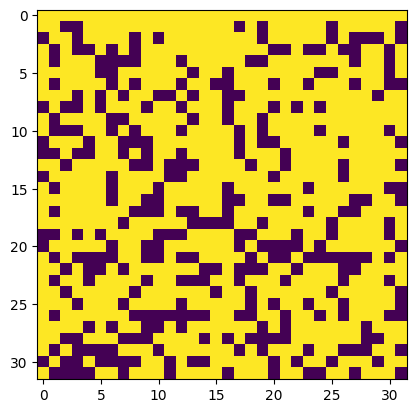

In [137]:
map = torch.rand(32, 32)<0.7
map[0] = True
plt.imshow(map.numpy())

In [122]:
class GridEnv(gym.Env):
    def __init__(self, map, n_envs, death=False, device=None):
        super().__init__()
        self.map, self.n_envs, self.death, self.device = map.to(device), n_envs, death, device
        self._actions = torch.tensor([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1]], dtype=torch.long, device=self.device)
        self.single_action_space = gym.spaces.Discrete(len(self._actions))
        self.action_space = gym.spaces.MultiDiscrete([len(self._actions) for _ in range(self.n_envs)])

    def _construct_obs(self, map, pos):
        n_envs = len(pos)
        obs = map.repeat(n_envs, 1, 1).to(torch.float32) - 1.
        obs[torch.arange(n_envs), pos[:, 0], pos[:, 1]] = 1.
        return obs[:, None, :, :], None
        
    def reset(self, *args, **kwargs):
        super().reset(*args, **kwargs)
        self.pos = torch.zeros(self.n_envs, 2, dtype=torch.long, device=self.device)
        obs, info = self._construct_obs(self.map, self.pos)
        return obs, info
        
    def step(self, action):
        if isinstance(action, (list, np.ndarray)):
            action = torch.as_tensor(action).to(self.device)
        action = self._actions[action]
        newpos = self.pos+action
        newpos = newpos.clamp(0, len(self.map))
        rew = torch.zeros(self.n_envs, device=self.device)
        term, trunc = torch.zeros(self.n_envs, dtype=bool, device=self.device), torch.zeros(self.n_envs, dtype=bool, device=self.device)
        lava = ~self.map[newpos[:, 0], newpos[:, 1]]
        if self.death:
            self.pos = torch.where(lava[:, None], torch.zeros_like(self.pos), newpos)
            term[lava] = True
        else:
            self.pos = torch.where(lava[:, None], self.pos, newpos)
        obs, info = self._construct_obs(self.map, self.pos)
        return obs, rew, term, trunc, info
                
    def all_possible_obs(self, flat=False):
        y, x = torch.arange(len(self.map), device=self.device), torch.arange(len(self.map), device=self.device)
        y, x = torch.meshgrid(y, x, indexing='ij')
        pos = torch.stack([y, x], dim=-1)
        pos = pos.reshape(-1, 2)
        obs, info = self._construct_obs(self.map, pos)
        if flat:
            return obs.reshape(-1, 1, len(self.map), len(self.map))
        else:
            return obs.reshape(len(self.map), len(self.map), 1, len(self.map), len(self.map))

env = GridEnv(map, 128, death=True)
obs, info = env.reset()
obs, rew, term, trunc, info = env.step([2])

In [123]:
obs.shape

torch.Size([128, 1, 16, 16])

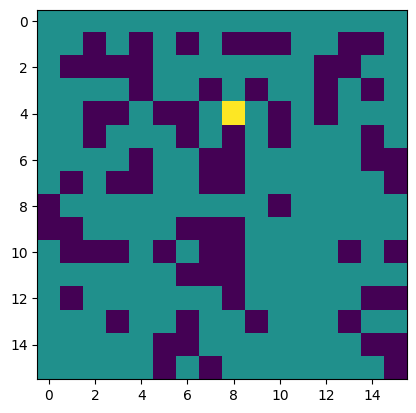

In [124]:
plt.imshow(env.all_possible_obs()[4,8, 0].numpy())

In [130]:
def plot_basis_rewmaps(env, net, goal_sample='eye', vmin=None, vmax=None):
    with torch.no_grad():
        latent = net(env.all_possible_obs(flat=True))
        print(latent.shape)
    if goal_sample=='eye':
        goal = torch.eye(net.latent_dim)[:16]
    elif goal_sample=='latent':
        goal = latent[torch.randperm(len(latent))[:16]]
    elif goal_sample=='randn':
        goal = torch.randn(16, net.latent_dim)
        goal = goal/goal.norm(dim=-1, keepdim=True)
    # print(goal.shape, latent.shape)
    rewmap = (goal@latent.T).reshape(-1, len(env.map), len(env.map))
    # print(rewmap.shape)
    plt.figure(figsize=(10, 10))
    for i in range(len(goal)):
        plt.subplot(int(np.sqrt(len(goal))), int(np.sqrt(len(goal))), i+1)
        plt.imshow(rewmap[i].numpy(), vmin=vmin, vmax=vmax)
        plt.colorbar()
    plt.tight_layout()

In [131]:
def calc_rewmap(env, net, goal_sample='eye', n_goals=16):
    with torch.no_grad():
        latent = net(env.all_possible_obs(flat=True))
        # print(latent.shape)
    if goal_sample=='eye':
        goal = torch.eye(n_goals, net.latent_dim)
    elif goal_sample=='latent':
        goal = latent[torch.randint(low=0, high=len(latent), size=(n_goals,))]
    elif goal_sample=='randn':
        goal = torch.randn(n_goals, net.latent_dim)
        goal = goal/goal.norm(dim=-1, keepdim=True)
    rewmap = (goal@latent.T)
    rewmap = rearrange(rewmap, 'b (h w) -> b h w', h=len(env.map))
    return rewmap

In [132]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer
    
class Net(nn.Module):
    def __init__(self, latent_dim=4, normalize=True):
        super().__init__()
        self.latent_dim = latent_dim
        self.normalize = normalize
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(1, 16, 3, padding=1, stride=1)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(16, 32, 3, padding=1, stride=2)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(32, 32, 3, padding=1, stride=1)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(32, 32, 3, padding=1, stride=2)),
            nn.LeakyReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(512, latent_dim)),
        )
    def forward(self, x):
        x = self.network(x)
        if self.normalize:
            x = x/x.norm(p=2, dim=-1, keepdim=True)
        return x

net = Net(latent_dim=16)
obs, info = env.reset()
net(obs).shape

torch.Size([128, 16])

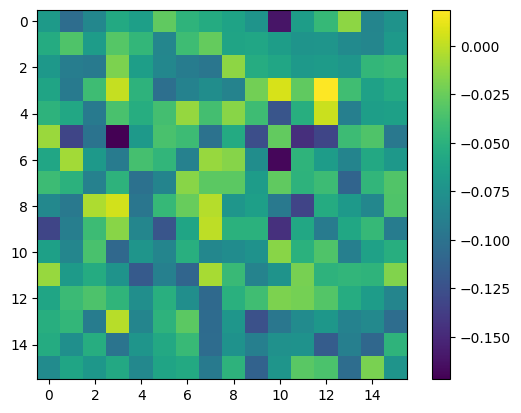

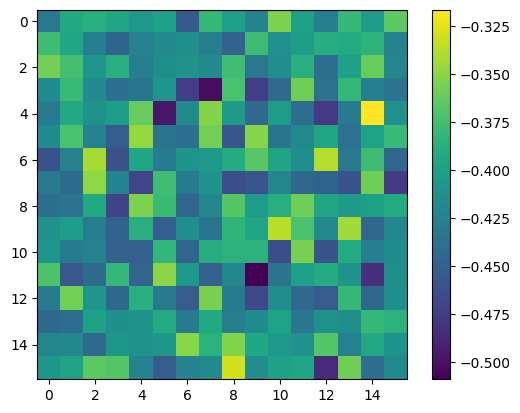

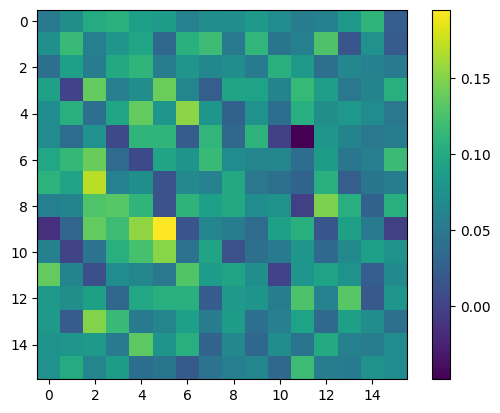

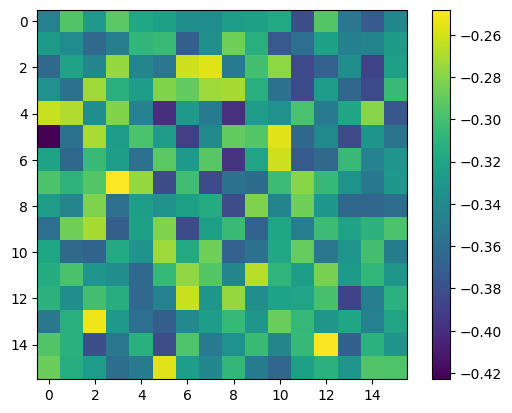

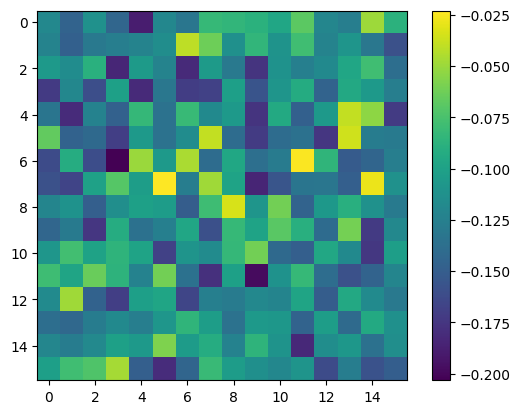

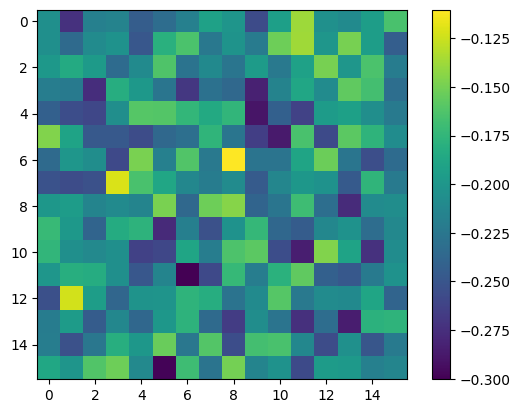

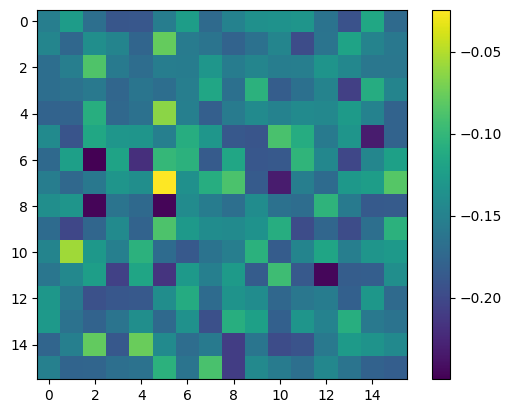

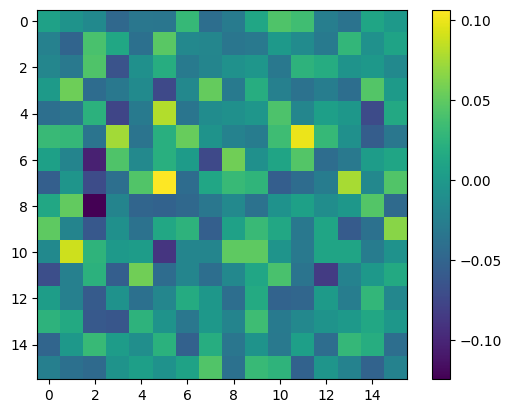

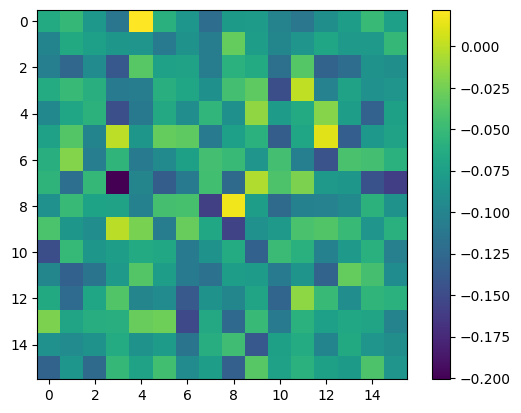

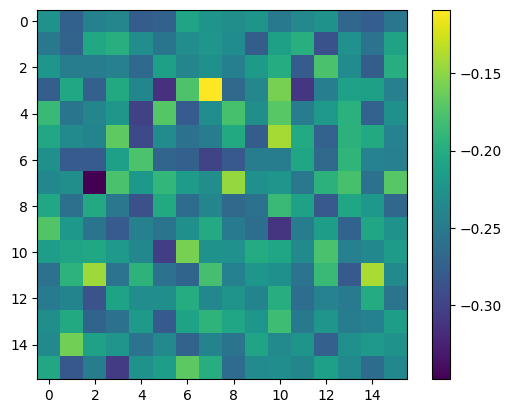

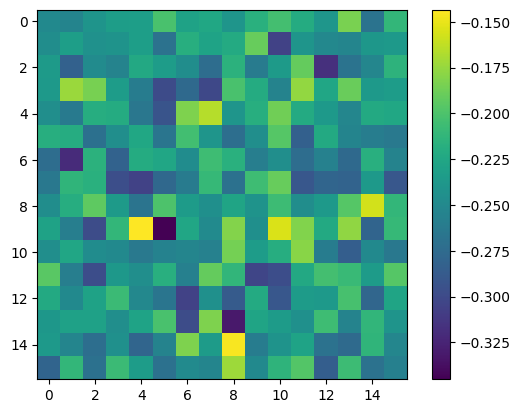

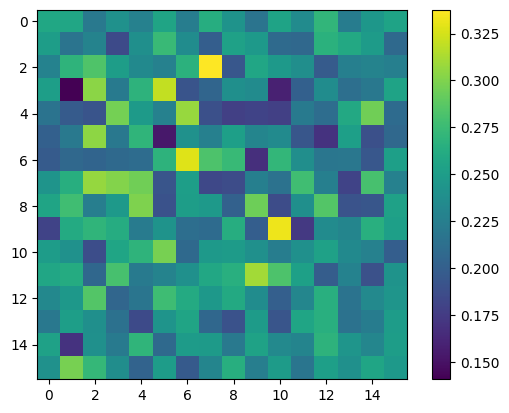

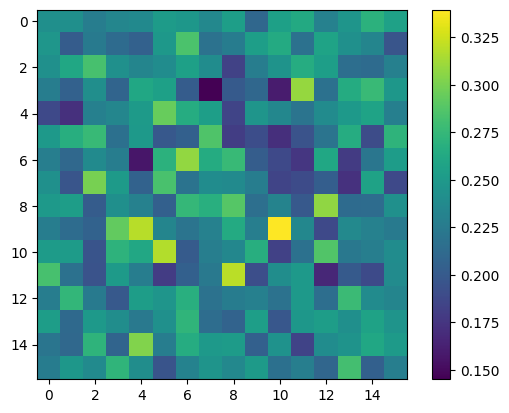

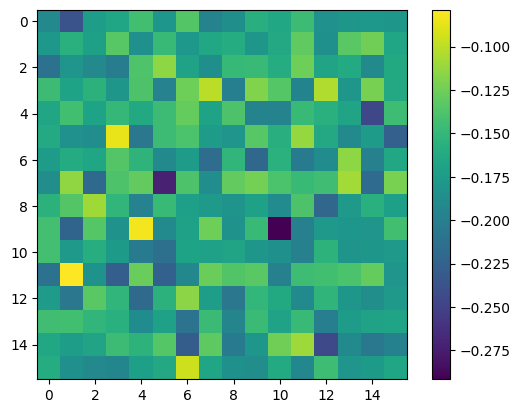

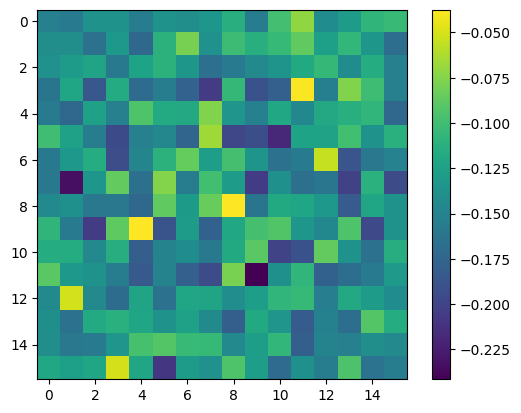

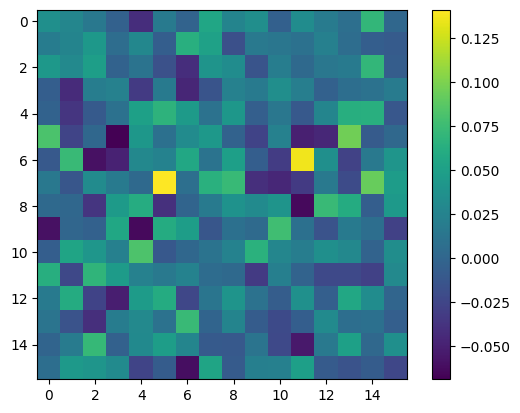

In [111]:
goal_sample = 'randn'

a = calc_rewmap(env, net, goal_sample=goal_sample, n_goals=16)
for i in range(16):
    plt.imshow(a[i])
    plt.colorbar()
    plt.show()
    

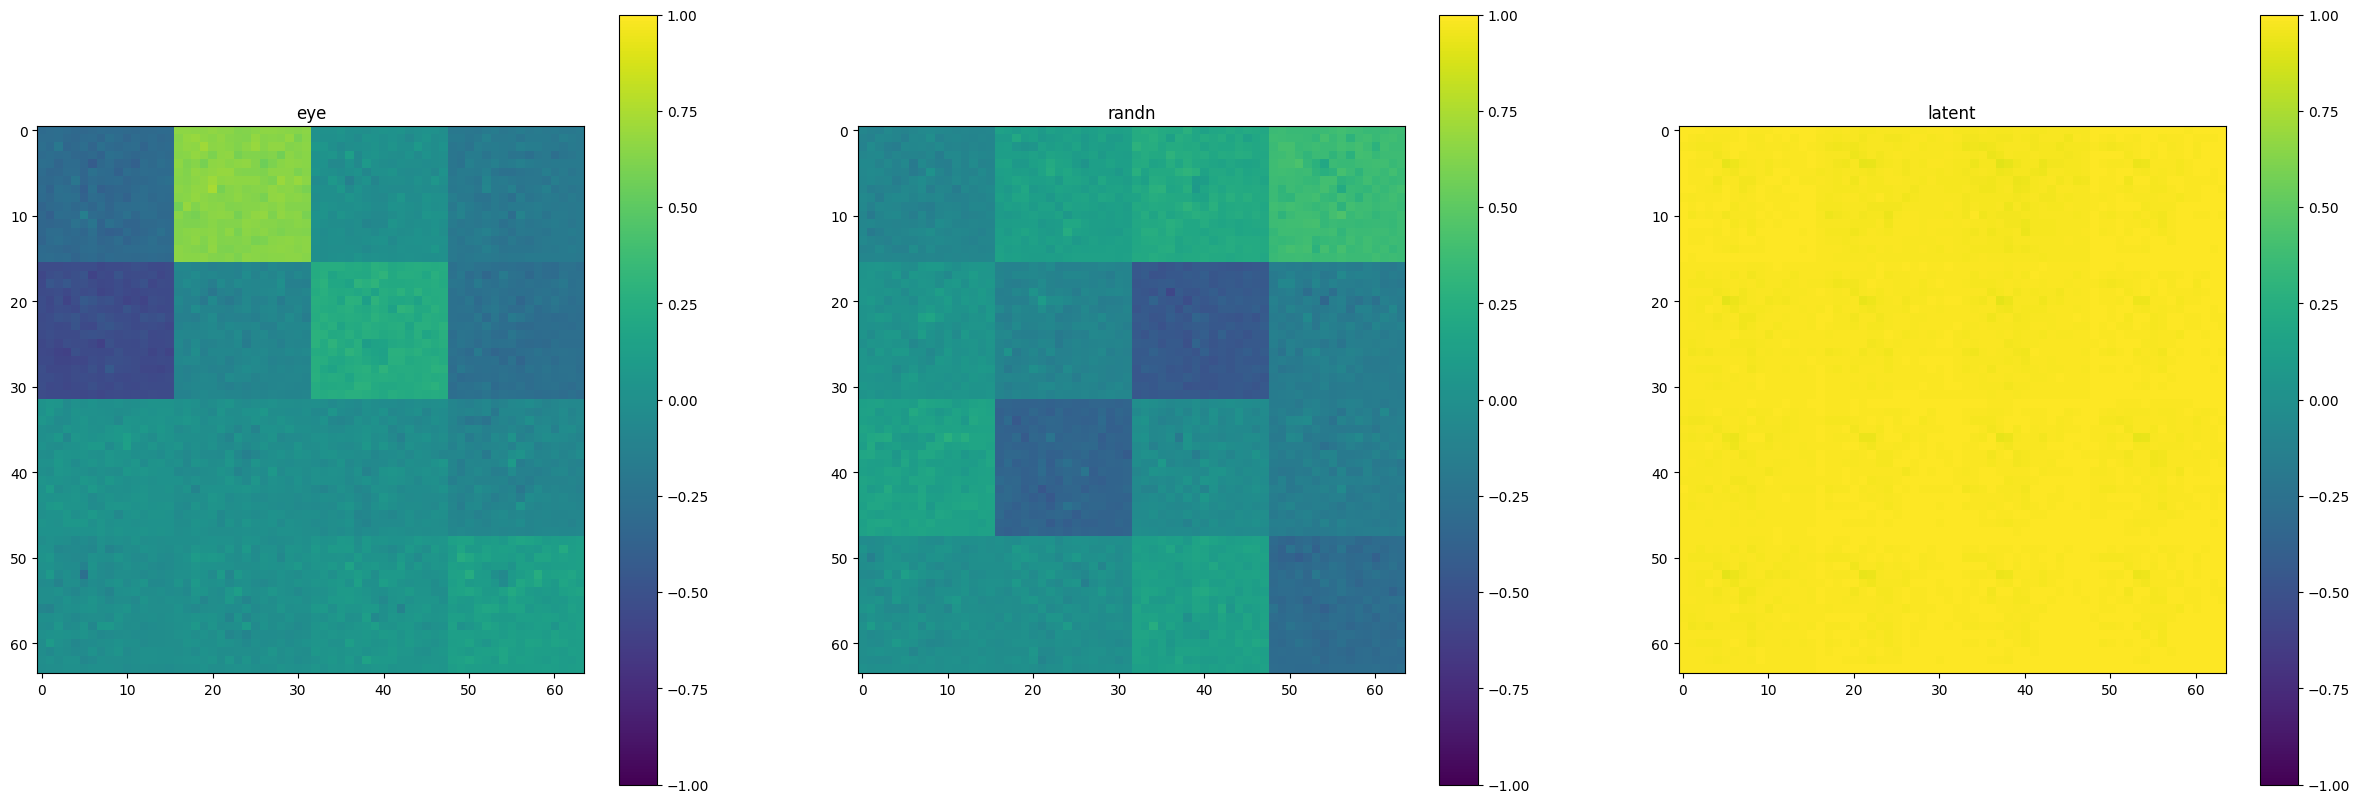

In [133]:
plt.figure(figsize=(30, 10))
for i, goal_sample in enumerate(['eye', 'randn', 'latent']):
    plt.subplot(1, 3, i+1)
    plt.title(goal_sample)
    plt.imshow(rearrange(calc_rewmap(env, net, goal_sample=goal_sample, n_goals=16), '(H W) h w -> (H h) (W w)', H=4), vmin=-1., vmax=1.)
    plt.colorbar()

In [134]:
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

def lalign(x, y, alpha=2):
    return (x - y).norm(dim=1).pow(alpha).mean()
def lunif(x, t=2):
    sq_pdist = torch.pdist(x, p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()
    
obs_all = env.all_possible_obs(flat=True)
for i in range(1000):
    latent = net(obs_all)
    a = latent.reshape(len(env.map), len(env.map), -1)
    if np.random.rand()<1.0:
        x, y = a[:-1, :].flatten(0, 1), a[1:, :].flatten(0, 1)
    else:
        x, y = a[:, :-1].flatten(0, 1), a[:, 1:].flatten(0, 1)
    loss1 = lalign(x, y)
    loss2 = (lunif(x) + lunif(y)) / 2
    loss = 1.*loss1 + 1.0 *loss2
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i%30==0:
        print(f'{i=}, {loss.item()}, {loss1.item()}, {loss2.item()}')

i=0, -0.03654465451836586, 0.025982435792684555, -0.06252709031105042
i=30, -1.8060634136199951, 1.367093563079834, -3.173156976699829
i=60, -2.1583735942840576, 1.3026230335235596, -3.460996627807617
i=90, -2.316922664642334, 1.1272693872451782, -3.4441919326782227
i=120, -2.437992572784424, 0.9959650635719299, -3.433957576751709
i=150, -2.5381031036376953, 0.8908411264419556, -3.4289441108703613
i=180, -2.621964931488037, 0.8029425740242004, -3.4249074459075928
i=210, -2.693755865097046, 0.7301176190376282, -3.4238734245300293
i=240, -2.754819631576538, 0.6703641414642334, -3.4251837730407715
i=270, -2.8092386722564697, 0.6206043362617493, -3.429842948913574
i=300, -2.857532024383545, 0.5768784284591675, -3.434410572052002
i=330, -2.8998095989227295, 0.5381070971488953, -3.4379167556762695
i=360, -2.9363789558410645, 0.5046234726905823, -3.441002368927002
i=390, -2.968386173248291, 0.47500452399253845, -3.4433906078338623
i=420, -2.998121976852417, 0.4480181336402893, -3.446140050888

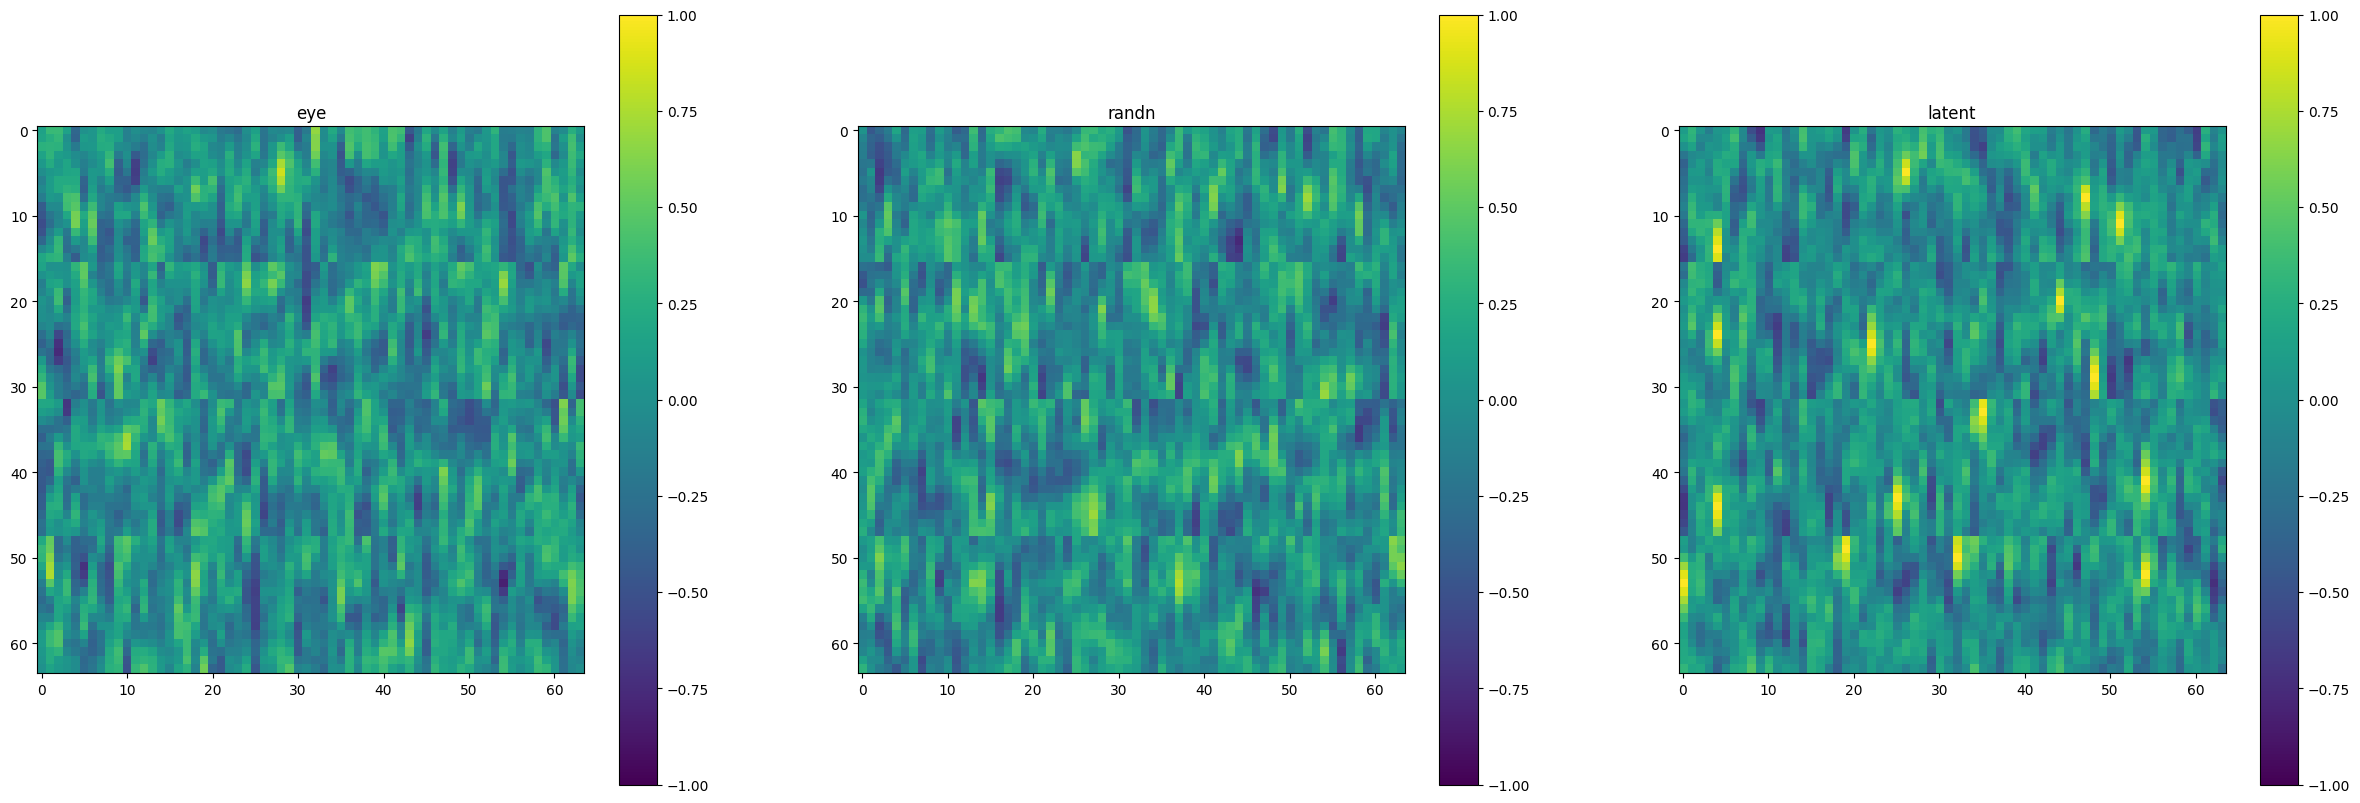

In [135]:
plt.figure(figsize=(30, 10))
for i, goal_sample in enumerate(['eye', 'randn', 'latent']):
    plt.subplot(1, 3, i+1)
    plt.title(goal_sample)
    plt.imshow(rearrange(calc_rewmap(env, net, goal_sample=goal_sample, n_goals=16), '(H W) h w -> (H h) (W w)', H=4), vmin=-1., vmax=1.)
    plt.colorbar()

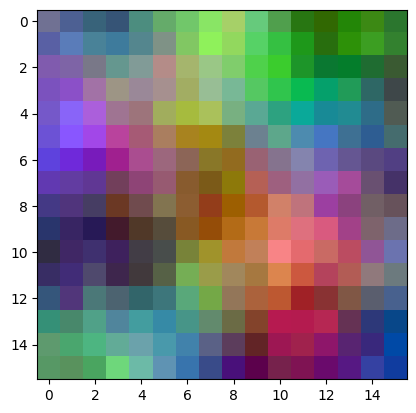

In [861]:
a = PCA(3).fit_transform(latent.detach().numpy())
a = (a-a.min())/(a.max()-a.min())
plt.imshow(a.reshape(16, 16, 3))

In [22]:
from sklearn.decomposition import PCA

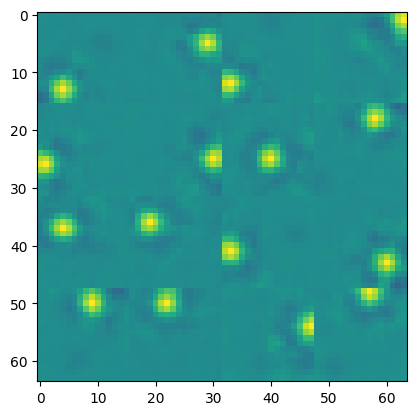

In [818]:
def temp(env, net, eps=0.0, n_goals=16):
    with torch.no_grad():
        latent = net(env.all_possible_obs(flat=True))        
    goal1 = latent[torch.randint(low=0, high=len(latent), size=(n_goals,))]
    goal2 = latent[torch.randint(low=0, high=len(latent), size=(n_goals,))]
    # goal = (goal1+goal2)/2.
    goal = goal2+(goal2-goal1)/10.
    # goal = goal+1e-1*torch.randn_like(goal)
    goal = goal/goal.norm(dim=-1, keepdim=True)
    rewmap = (goal@latent.T)
    rewmap = rearrange(rewmap, 'b (h w) -> b h w', h=len(env.map))
    return rewmap

plt.imshow(rearrange(temp(env, net, eps=0., n_goals=16), '(H W) h w -> (H h) (W w)', H=4), vmin=-1., vmax=1.)

In [32]:
def lalign(x, y, alpha=2):
    return (x - y).norm(dim=1).pow(alpha).mean()
def lunif(x, t=2):
    sq_pdist = torch.pdist(x, p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()
    

latent_dim=2


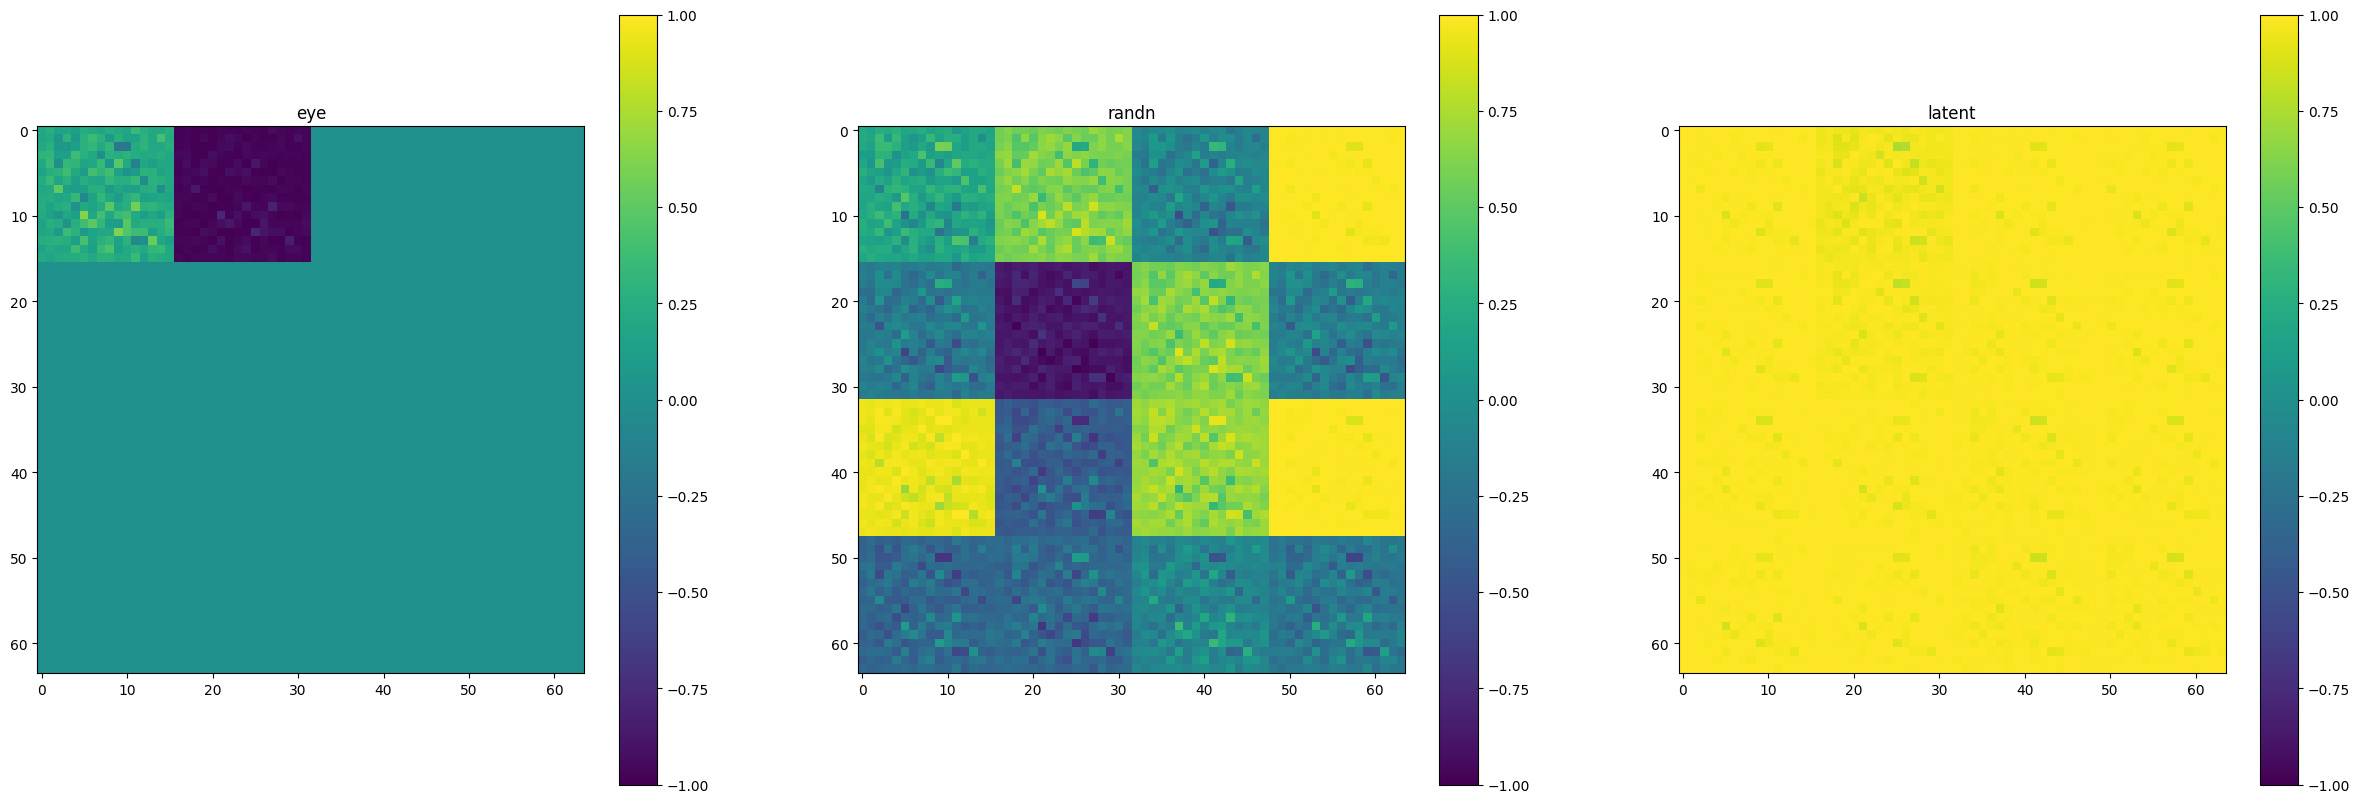

i=0, -0.026286007836461067, 0.02953079156577587, -0.05581679940223694
i=30, -0.2601613700389862, 0.3279155194759369, -0.5880768895149231
i=60, -0.4819681942462921, 0.49167296290397644, -0.9736411571502686
i=90, -0.6474474668502808, 0.2876277565956116, -0.9350752234458923
i=120, -0.7889021039009094, 0.35514944791793823, -1.1440515518188477
i=150, -0.9326808452606201, 0.2754351794719696, -1.208116054534912
i=180, -0.517214834690094, 0.10996051877737045, -0.6271753311157227
i=210, -0.7727581858634949, 0.6058192849159241, -1.378577470779419
i=240, -1.0069433450698853, 0.30900096893310547, -1.3159443140029907
i=270, -1.0629417896270752, 0.29982227087020874, -1.3627641201019287
i=300, -1.1008937358856201, 0.3073754608631134, -1.4082691669464111
i=330, -1.1286532878875732, 0.27274289727211, -1.4013961553573608
i=360, -1.1771457195281982, 0.2624390721321106, -1.4395848512649536
i=390, -1.1861610412597656, 0.29016584157943726, -1.4763269424438477
i=420, -1.26170814037323, 0.22136272490024567, -

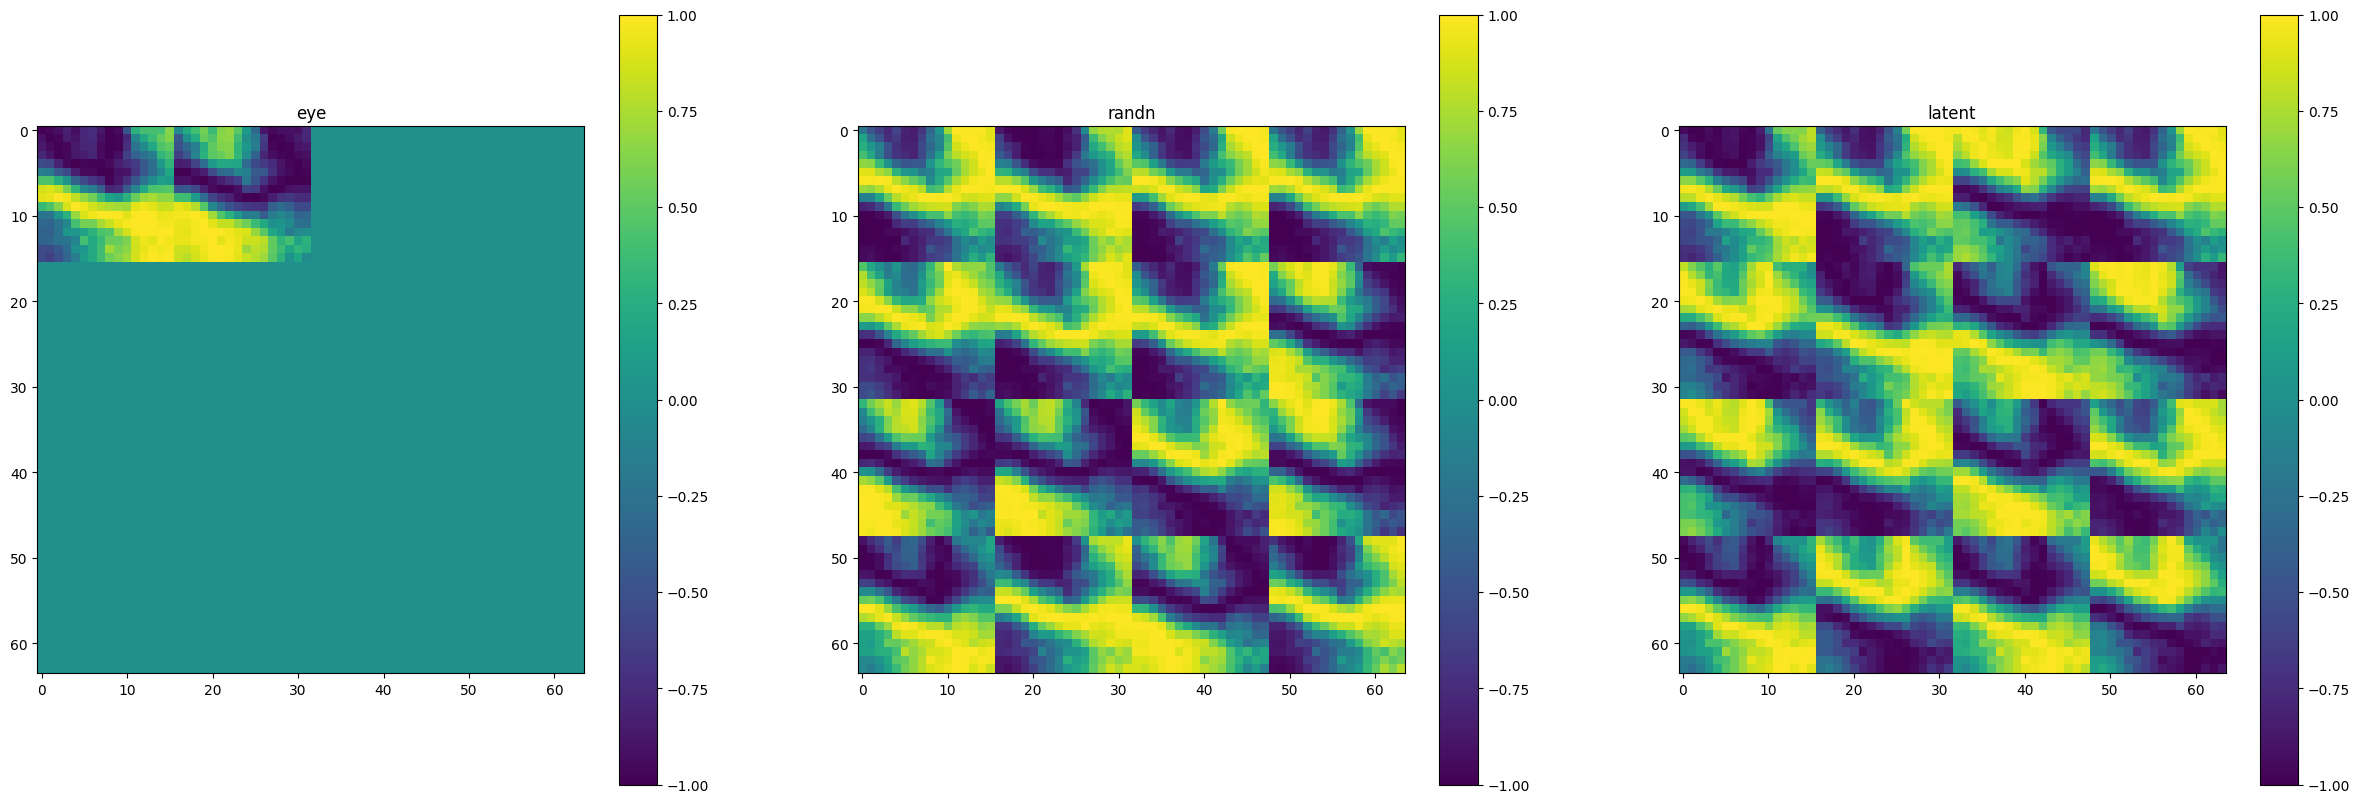

latent_dim=4


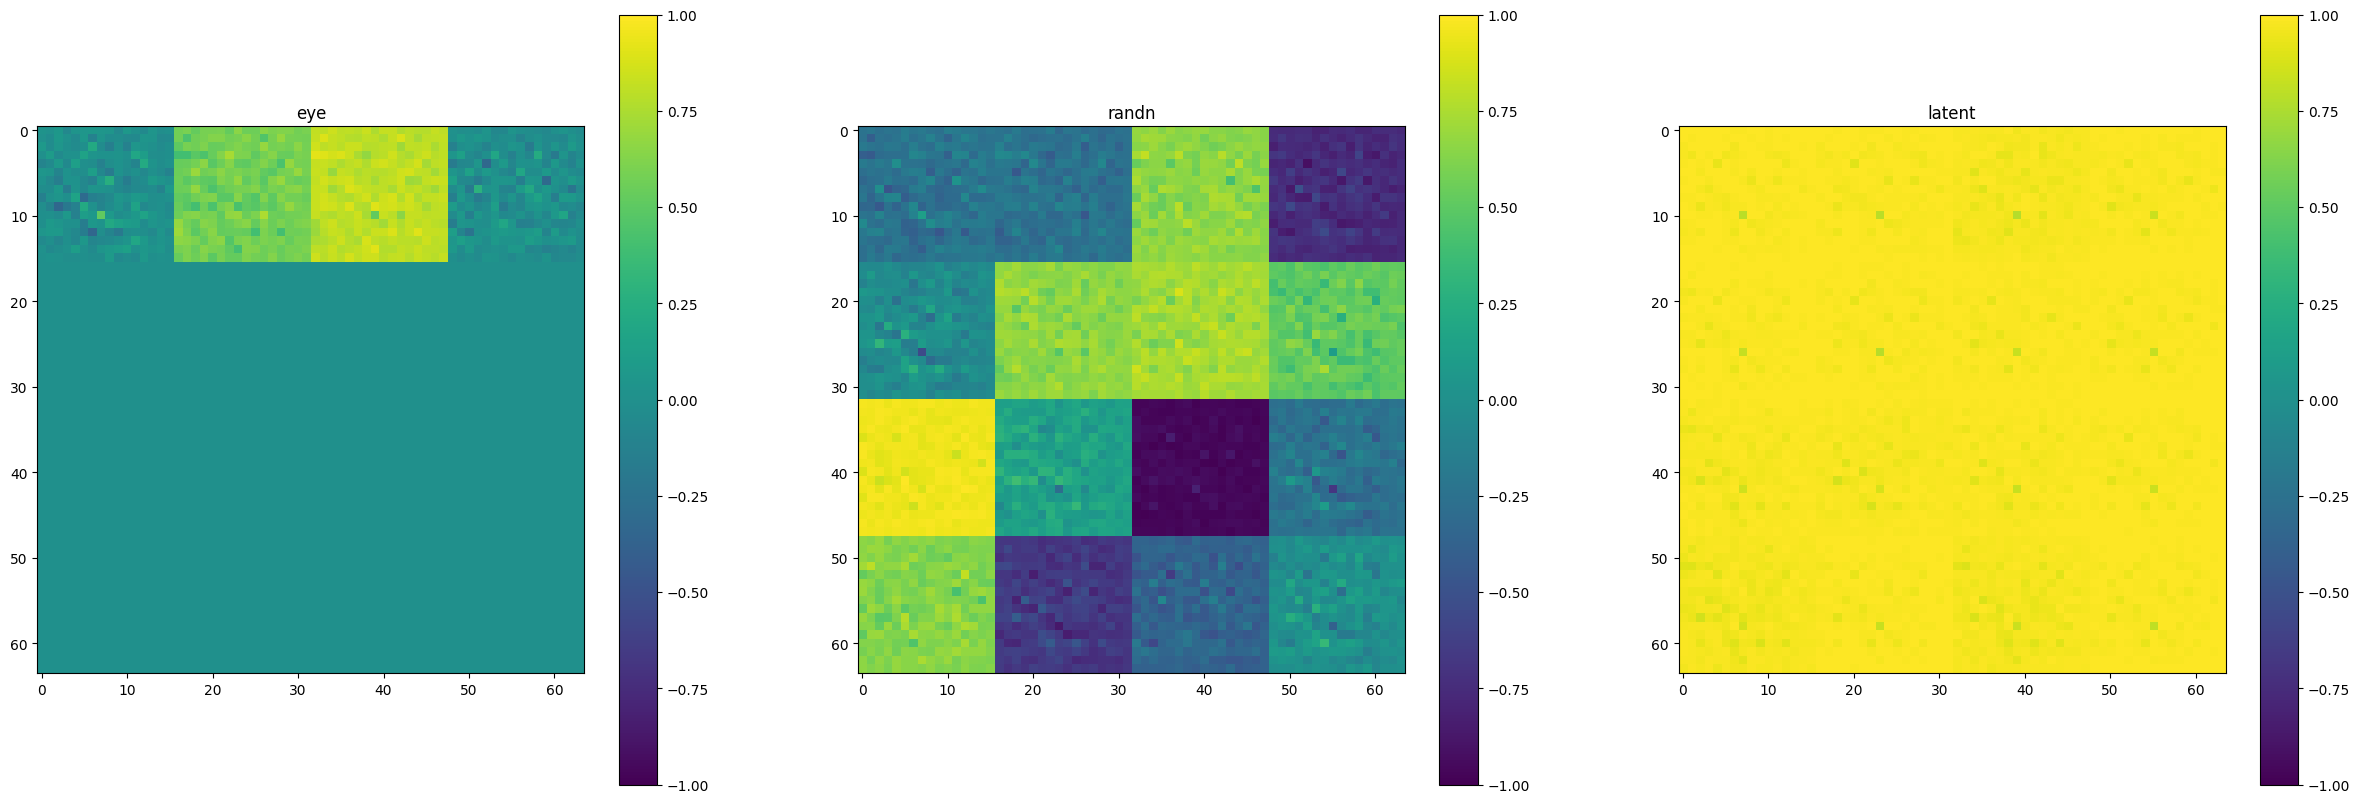

i=0, -0.035194575786590576, 0.04607235640287399, -0.08126693218946457
i=30, -0.7365962266921997, 1.6215232610702515, -2.358119487762451
i=60, -1.1432486772537231, 1.2461117506027222, -2.3893604278564453
i=90, -1.3750206232070923, 1.0032519102096558, -2.378272533416748
i=120, -1.5067421197891235, 0.8776129484176636, -2.384355068206787
i=150, -1.6608130931854248, 0.7163721919059753, -2.377185344696045
i=180, -1.741402268409729, 0.6293386220932007, -2.3707408905029297
i=210, -1.8057975769042969, 0.5628452301025391, -2.368642807006836
i=240, -1.8708115816116333, 0.4993947446346283, -2.370206356048584
i=270, -1.9380888938903809, 0.4365234971046448, -2.374612331390381
i=300, -1.991058111190796, 0.38427621126174927, -2.3753342628479004
i=330, -2.0203256607055664, 0.35509780049324036, -2.3754234313964844
i=360, -2.0436184406280518, 0.335202157497406, -2.3788206577301025
i=390, -2.089107036590576, 0.2919020354747772, -2.381009101867676
i=420, -2.0789222717285156, 0.30633294582366943, -2.3852553

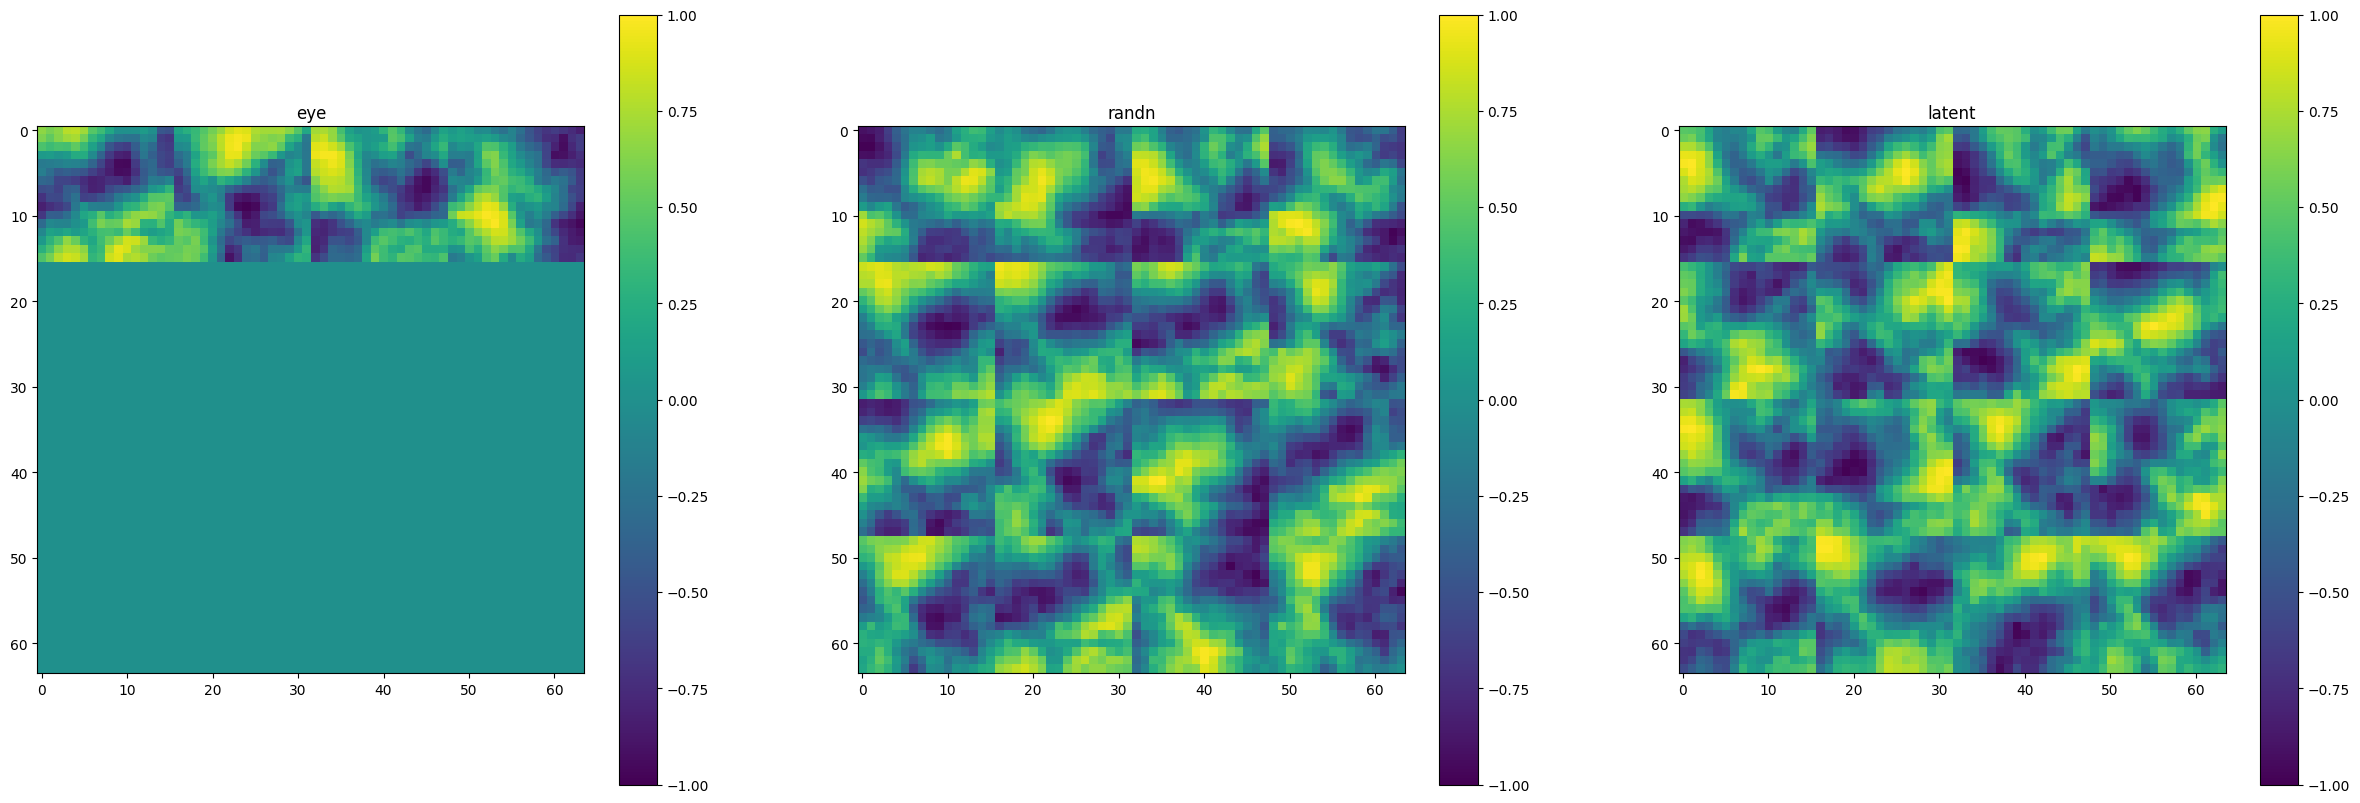

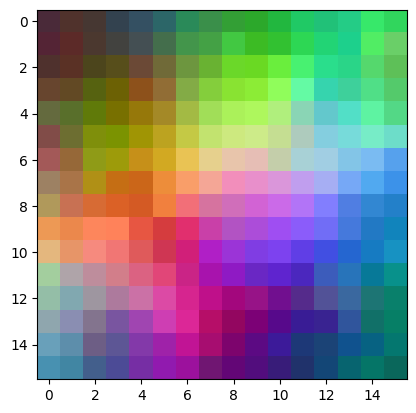

latent_dim=8


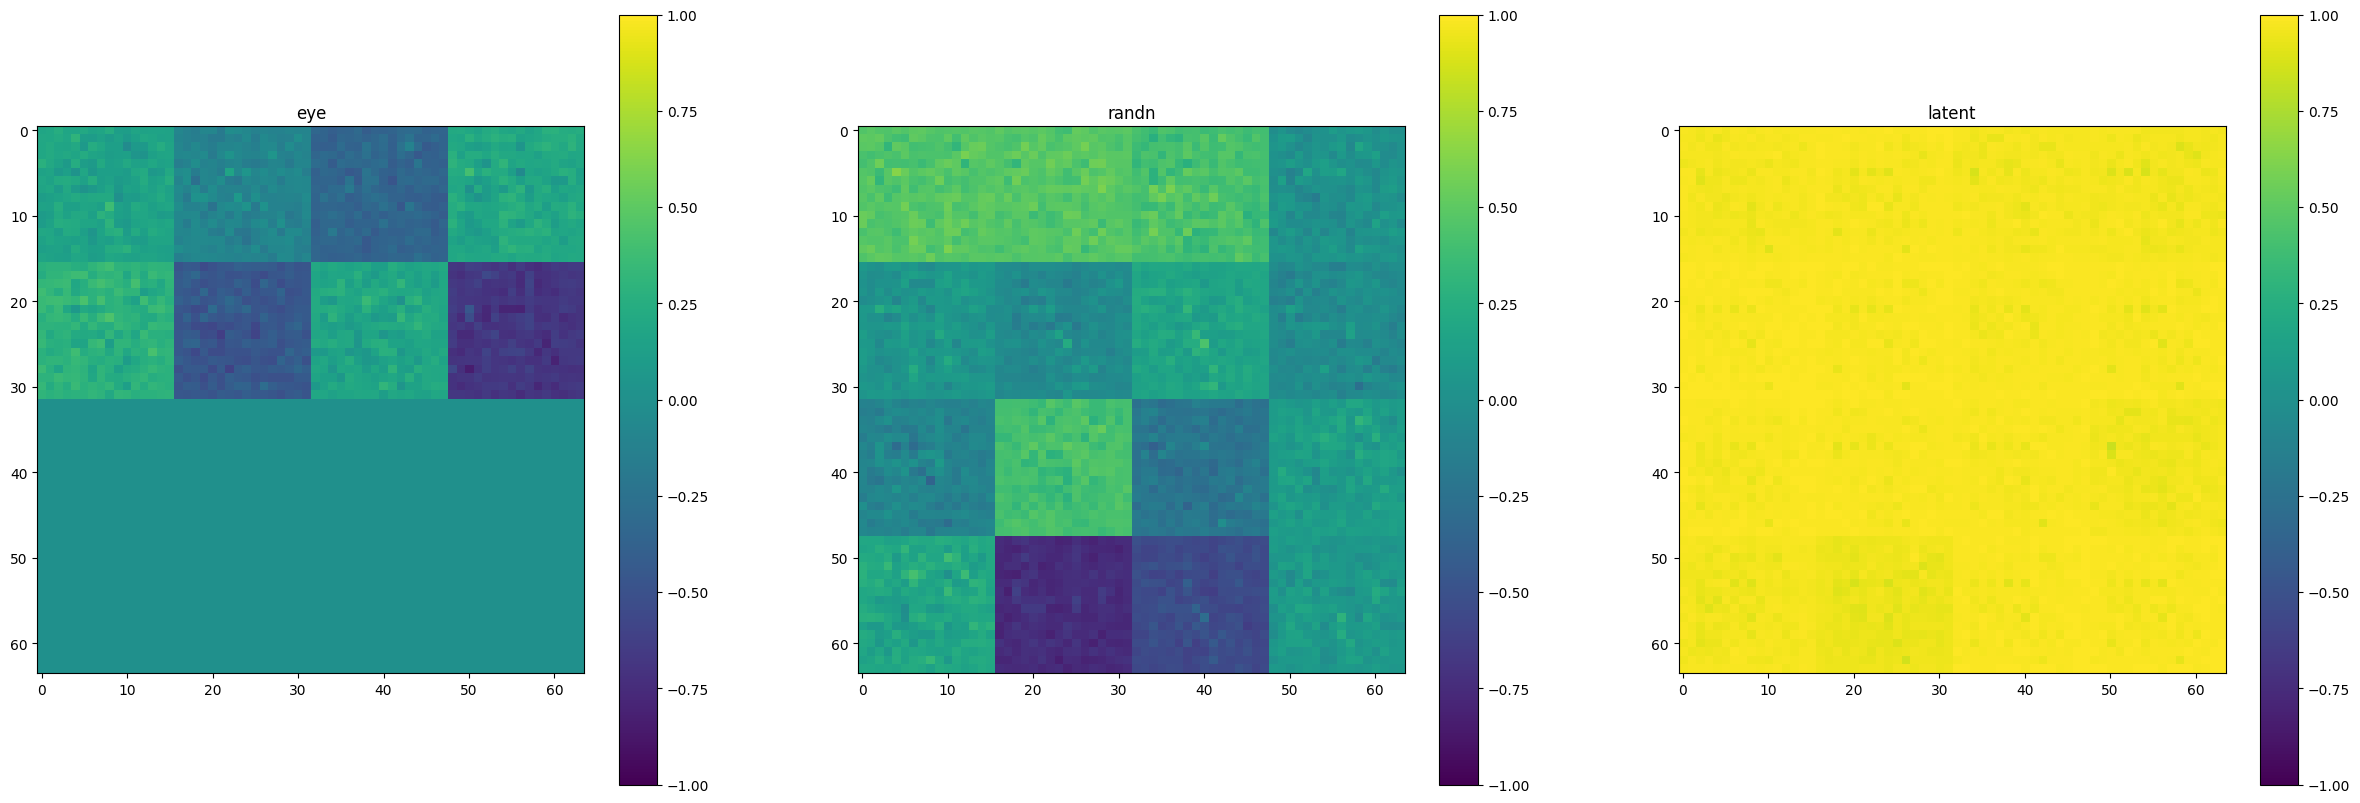

i=0, -0.05225874111056328, 0.04249892756342888, -0.09475766867399216
i=30, -1.4330826997756958, 1.5827285051345825, -3.0158112049102783
i=60, -1.5998094081878662, 1.4099504947662354, -3.0097599029541016
i=90, -1.8107008934020996, 1.2209622859954834, -3.031663179397583
i=120, -1.905166745185852, 1.0940650701522827, -2.9992318153381348
i=150, -2.01198148727417, 1.0070195198059082, -3.019001007080078
i=180, -2.0927209854125977, 0.9284244775772095, -3.0211453437805176
i=210, -2.190434217453003, 0.8290087580680847, -3.0194430351257324
i=240, -2.2197439670562744, 0.7981931567192078, -3.017937183380127
i=270, -2.304758071899414, 0.7094985246658325, -3.014256477355957
i=300, -2.348234176635742, 0.6615989208221436, -3.0098330974578857
i=330, -2.3856723308563232, 0.6220476627349854, -3.0077199935913086
i=360, -2.391528367996216, 0.6256845593452454, -3.0172128677368164
i=390, -2.421867847442627, 0.5941048860549927, -3.01597261428833
i=420, -2.473489999771118, 0.5394987463951111, -3.01298880577087

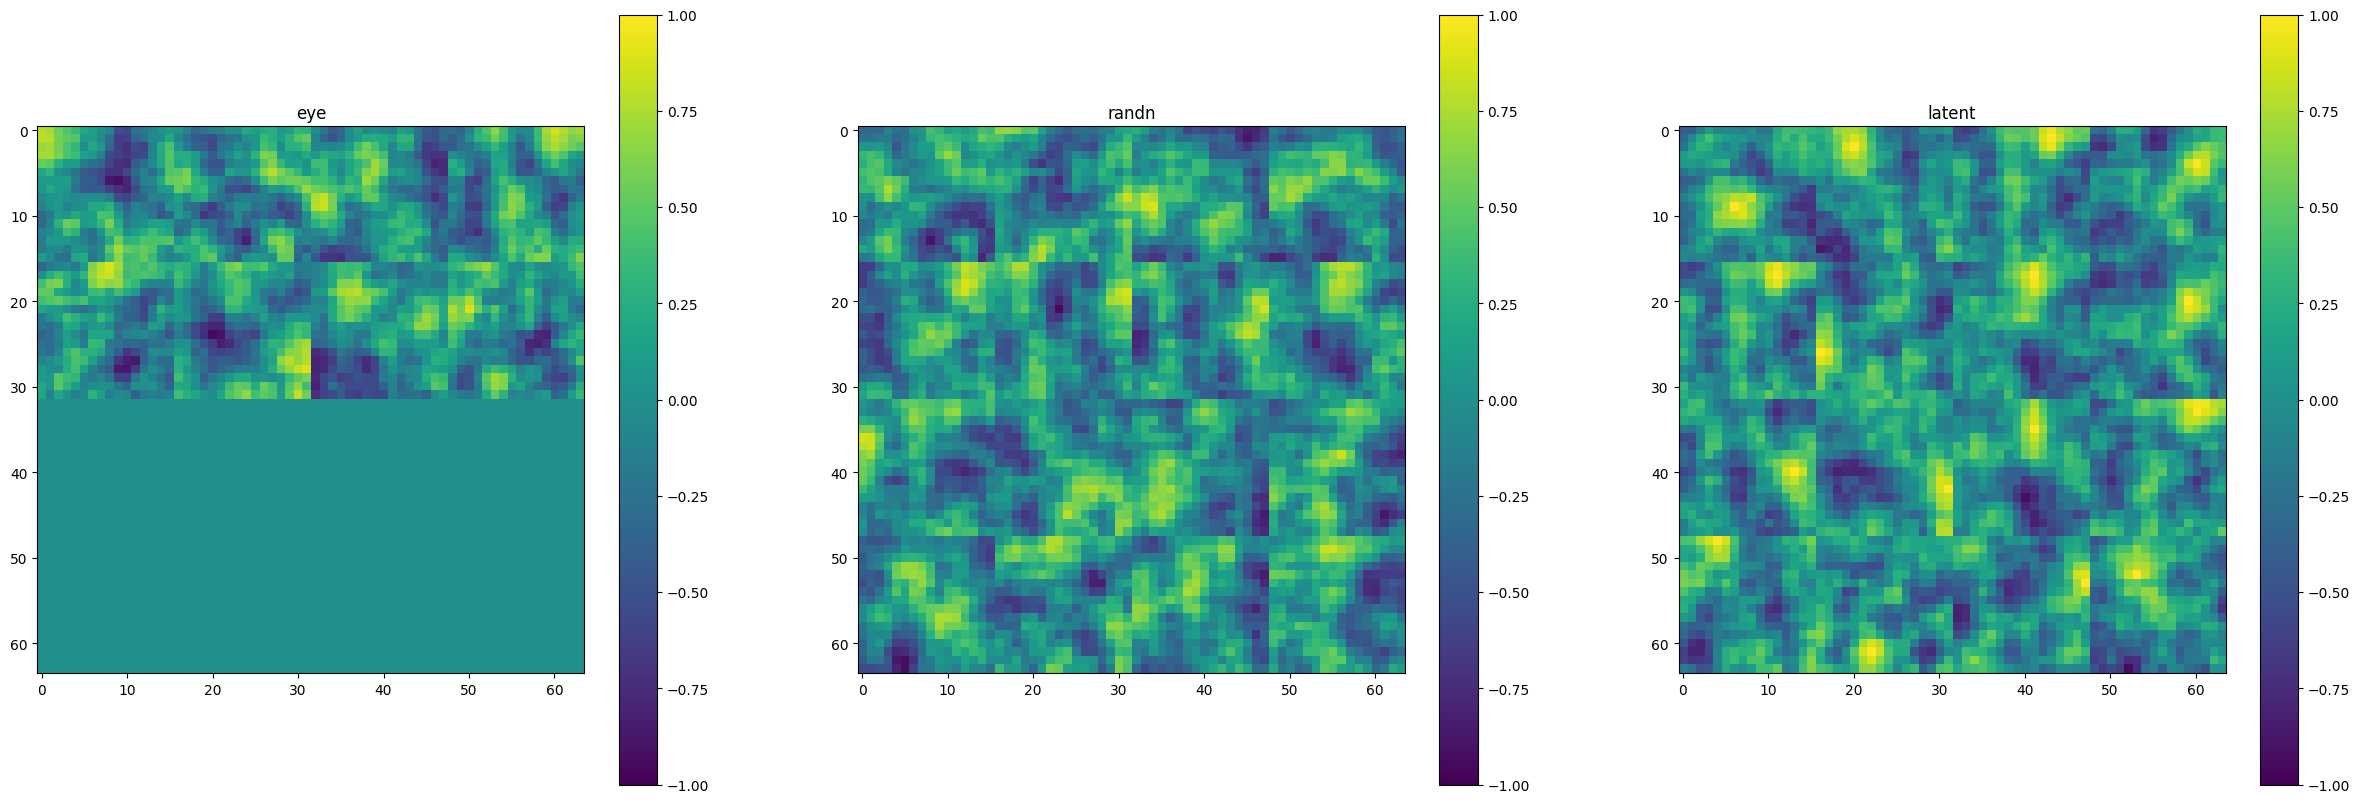

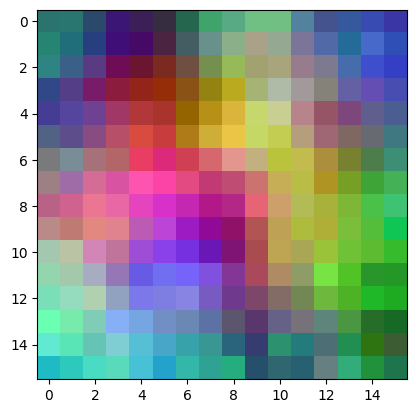

latent_dim=16


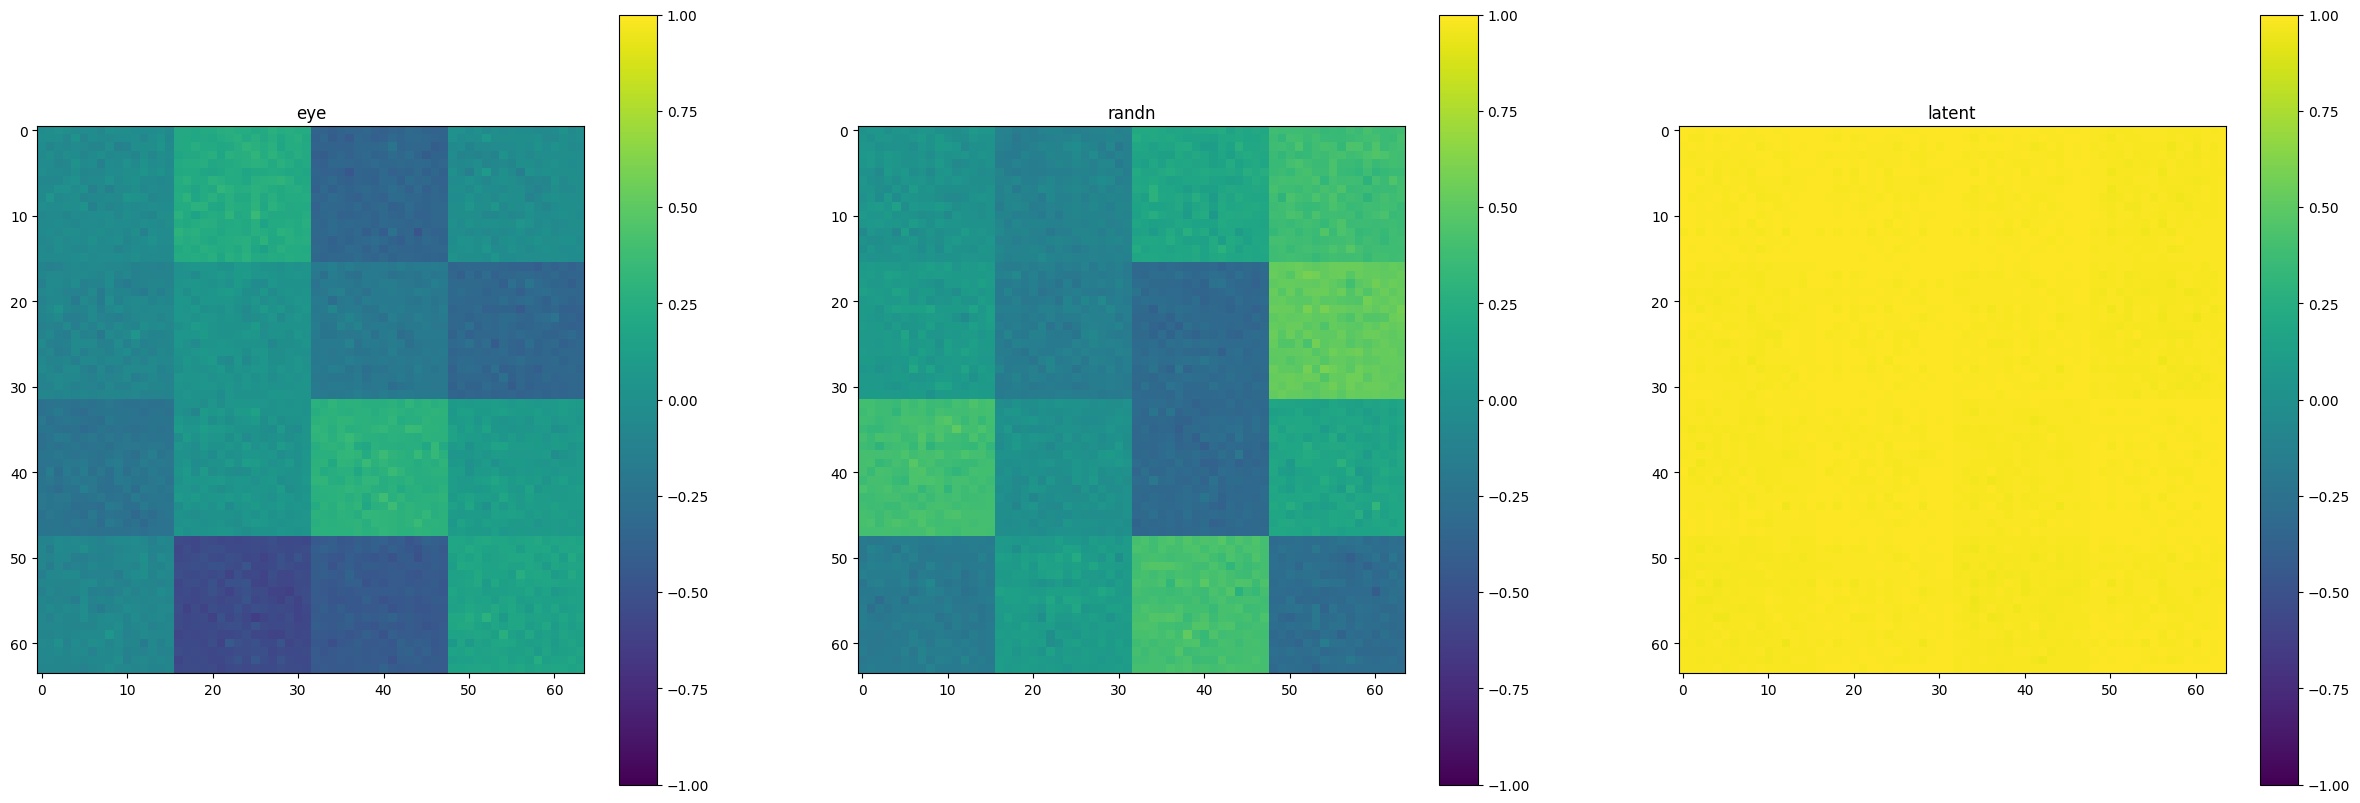

i=0, -0.032709866762161255, 0.027318667620420456, -0.06002853438258171
i=30, -1.8226264715194702, 1.4680253267288208, -3.290651798248291
i=60, -2.059000015258789, 1.3752877712249756, -3.4342877864837646
i=90, -2.1971993446350098, 1.2277165651321411, -3.4249157905578613
i=120, -2.297201633453369, 1.107866883277893, -3.4050683975219727
i=150, -2.378286361694336, 1.0087788105010986, -3.3870651721954346
i=180, -2.437027931213379, 0.9330334067344666, -3.3700613975524902
i=210, -2.4827611446380615, 0.875838577747345, -3.3585996627807617
i=240, -2.5397121906280518, 0.8212955594062805, -3.3610076904296875
i=270, -2.5758988857269287, 0.782457172870636, -3.35835599899292
i=300, -2.6079864501953125, 0.7370774149894714, -3.3450639247894287
i=330, -2.6324305534362793, 0.7212013006210327, -3.3536319732666016
i=360, -2.680577039718628, 0.6755192279815674, -3.3560962677001953
i=390, -2.680431842803955, 0.6775122284889221, -3.3579440116882324
i=420, -2.734320640563965, 0.6214051842689514, -3.3557257652

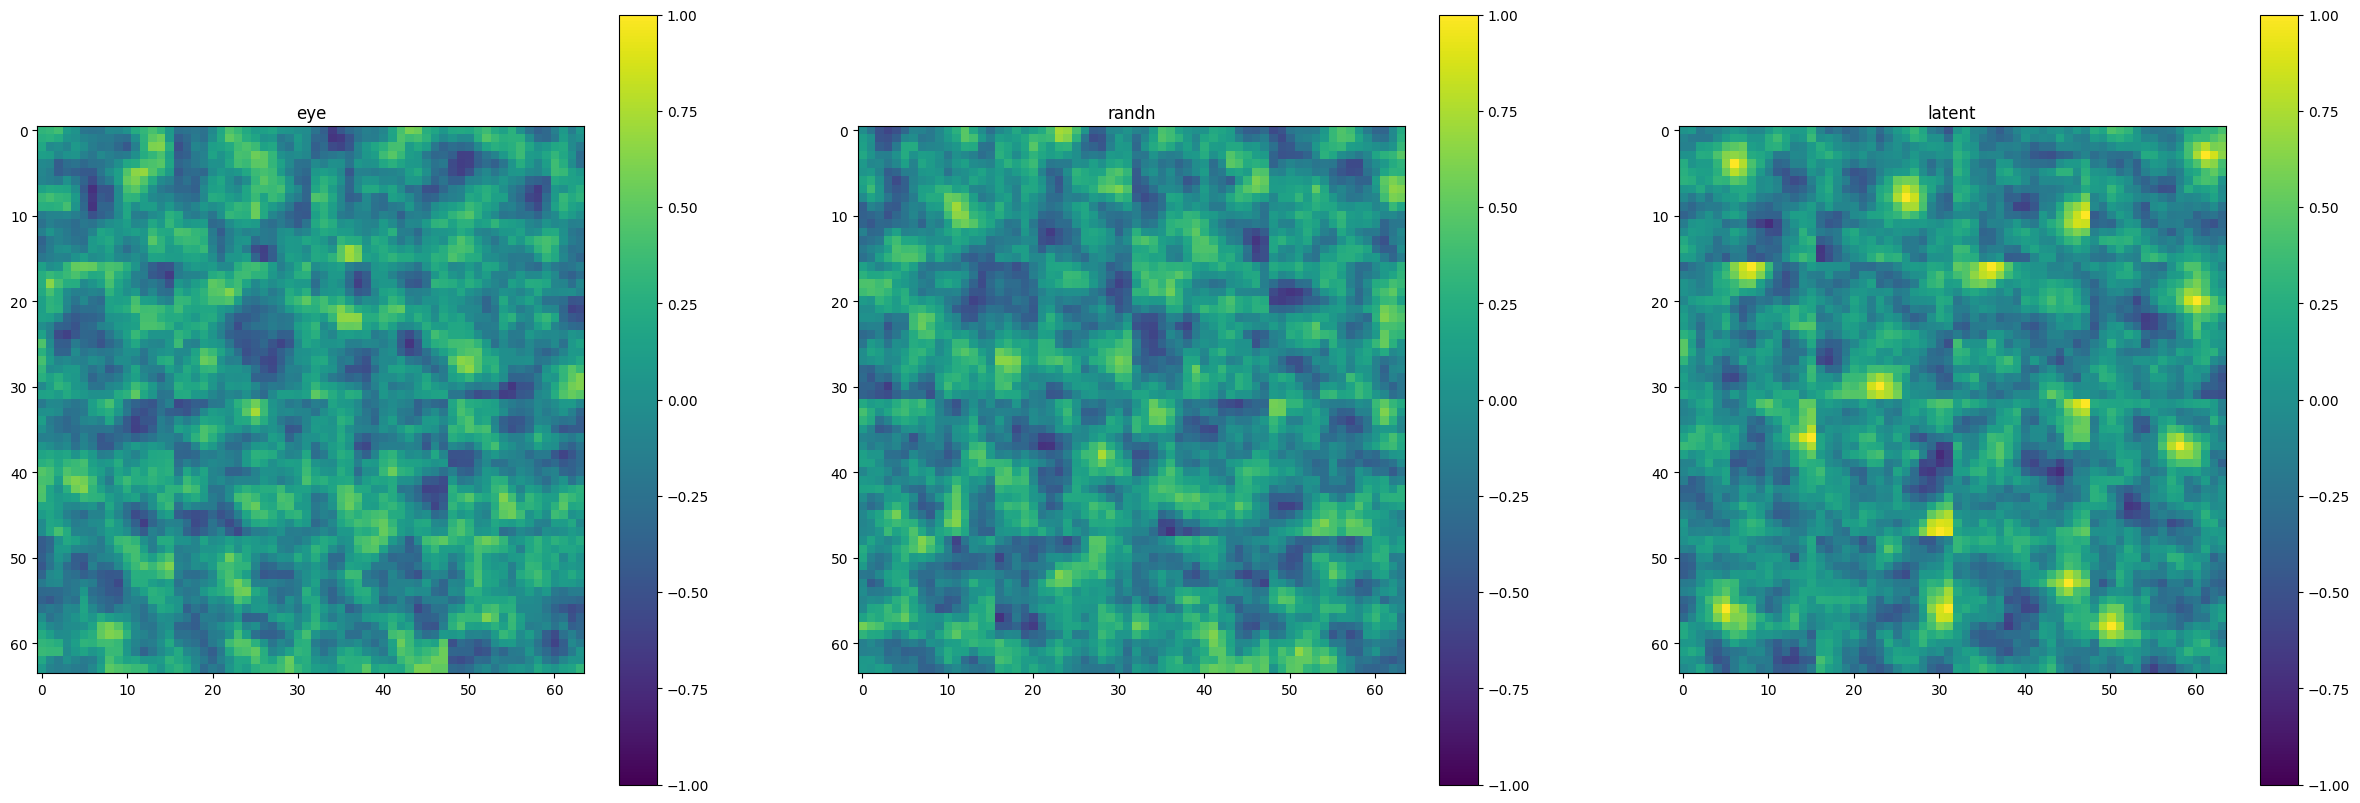

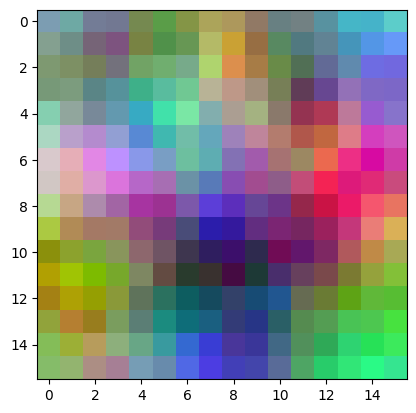

latent_dim=256


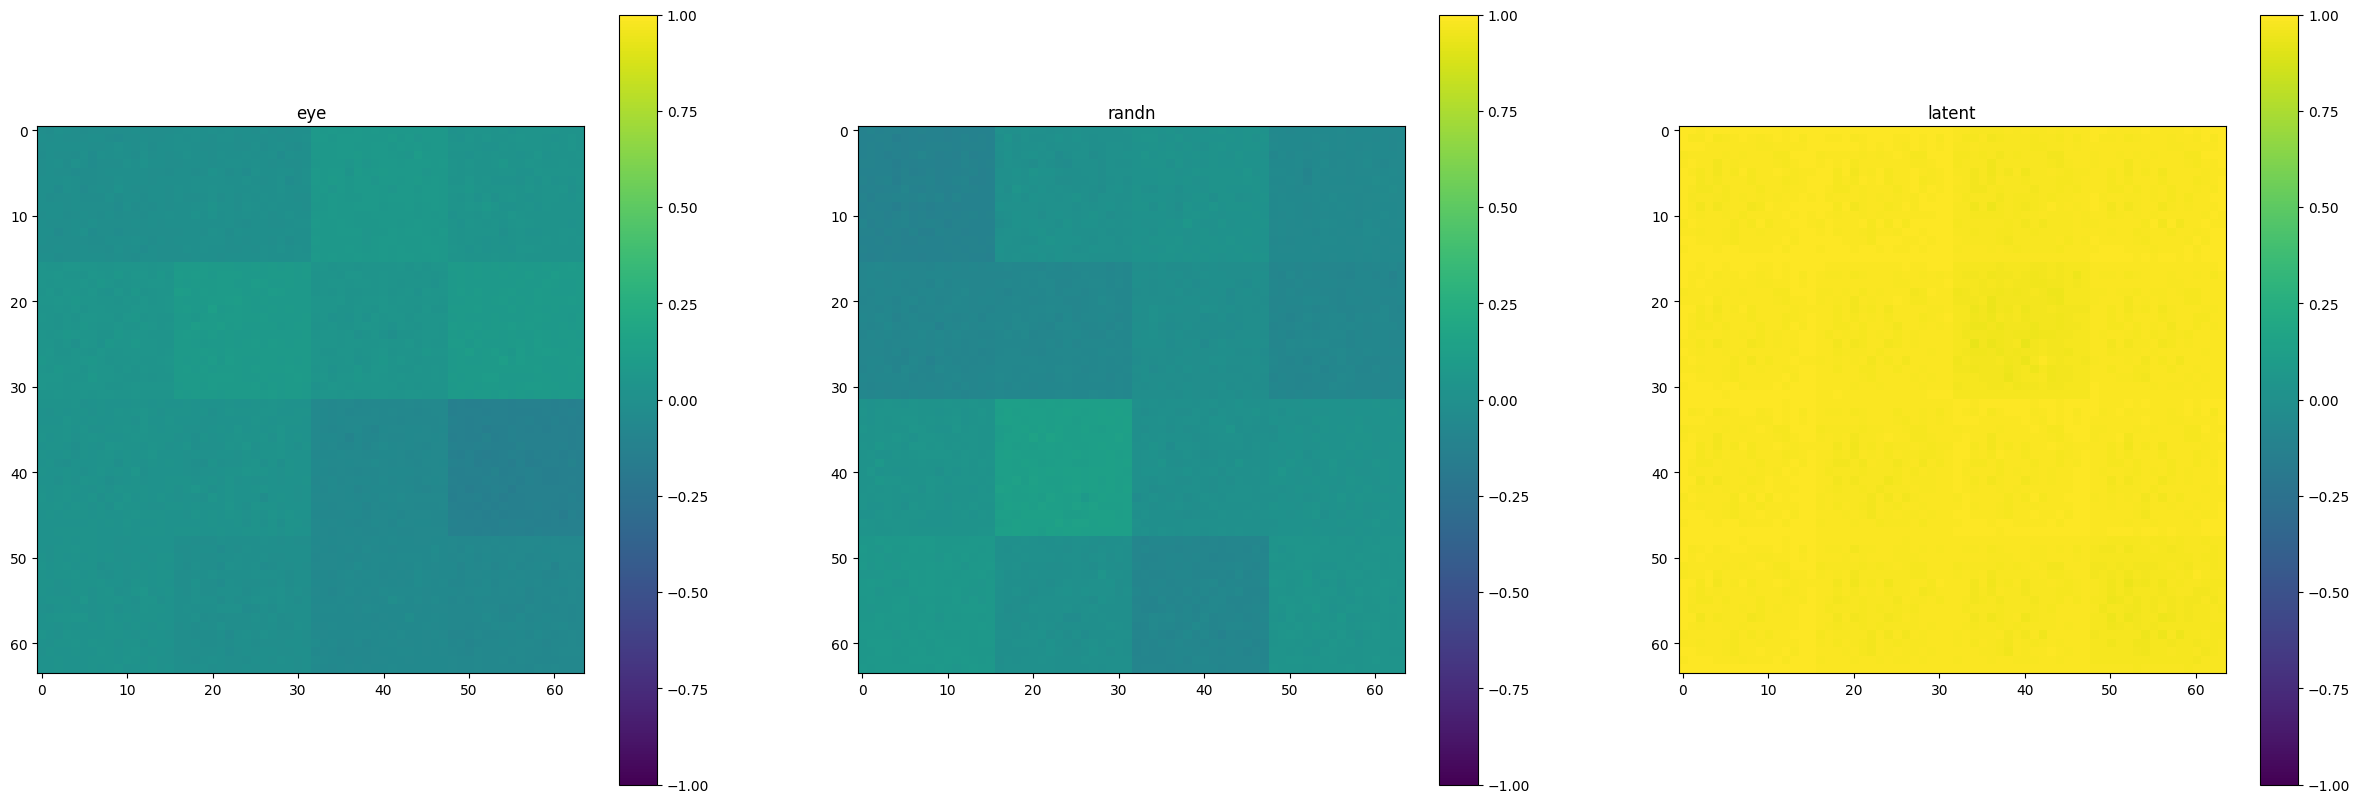

i=0, -0.040144212543964386, 0.030405351892113686, -0.07054956257343292
i=30, -0.6273483037948608, 0.4770289957523346, -1.104377269744873
i=60, -2.3947947025299072, 1.4363007545471191, -3.8310954570770264
i=90, -2.589479923248291, 1.2529288530349731, -3.8424086570739746
i=120, -2.6947014331817627, 1.0933301448822021, -3.788031578063965
i=150, -2.779834270477295, 0.9744950532913208, -3.754329204559326
i=180, -2.8497519493103027, 0.890367329120636, -3.740119218826294
i=210, -2.8986971378326416, 0.8241041302680969, -3.7228012084960938
i=240, -2.794912099838257, 0.9146128296852112, -3.7095248699188232
i=270, -2.9576945304870605, 0.7436344027519226, -3.701328992843628
i=300, -2.8669776916503906, 0.8311187028884888, -3.69809627532959
i=330, -3.022684097290039, 0.6707413196563721, -3.693425416946411
i=360, -3.028843879699707, 0.6562473177909851, -3.685091257095337
i=390, -2.9389028549194336, 0.747146487236023, -3.686049461364746
i=420, -3.071793556213379, 0.6072416305541992, -3.679035186767578

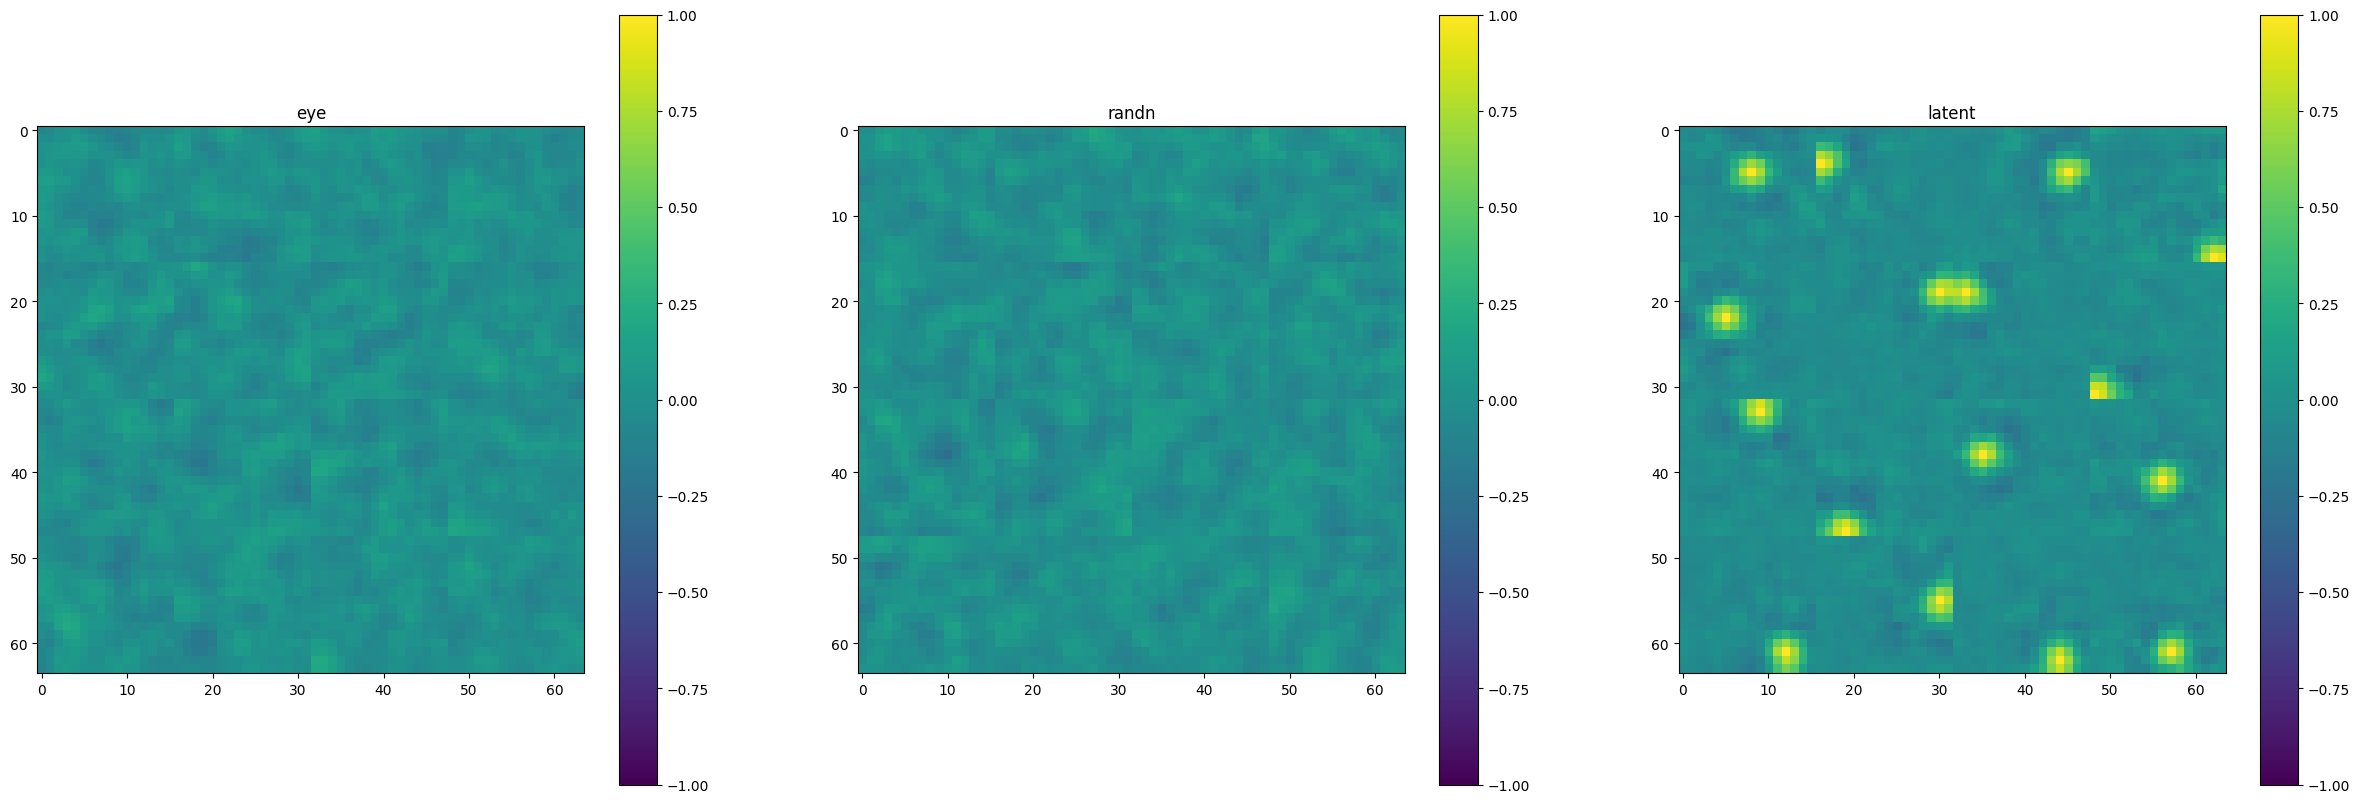

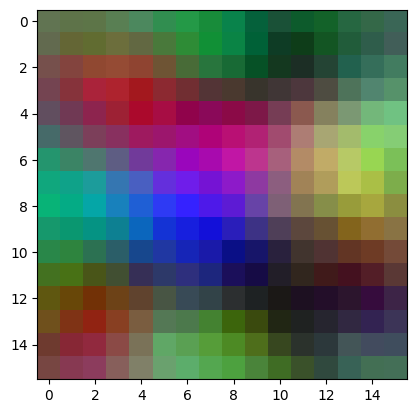

latent_dim=512


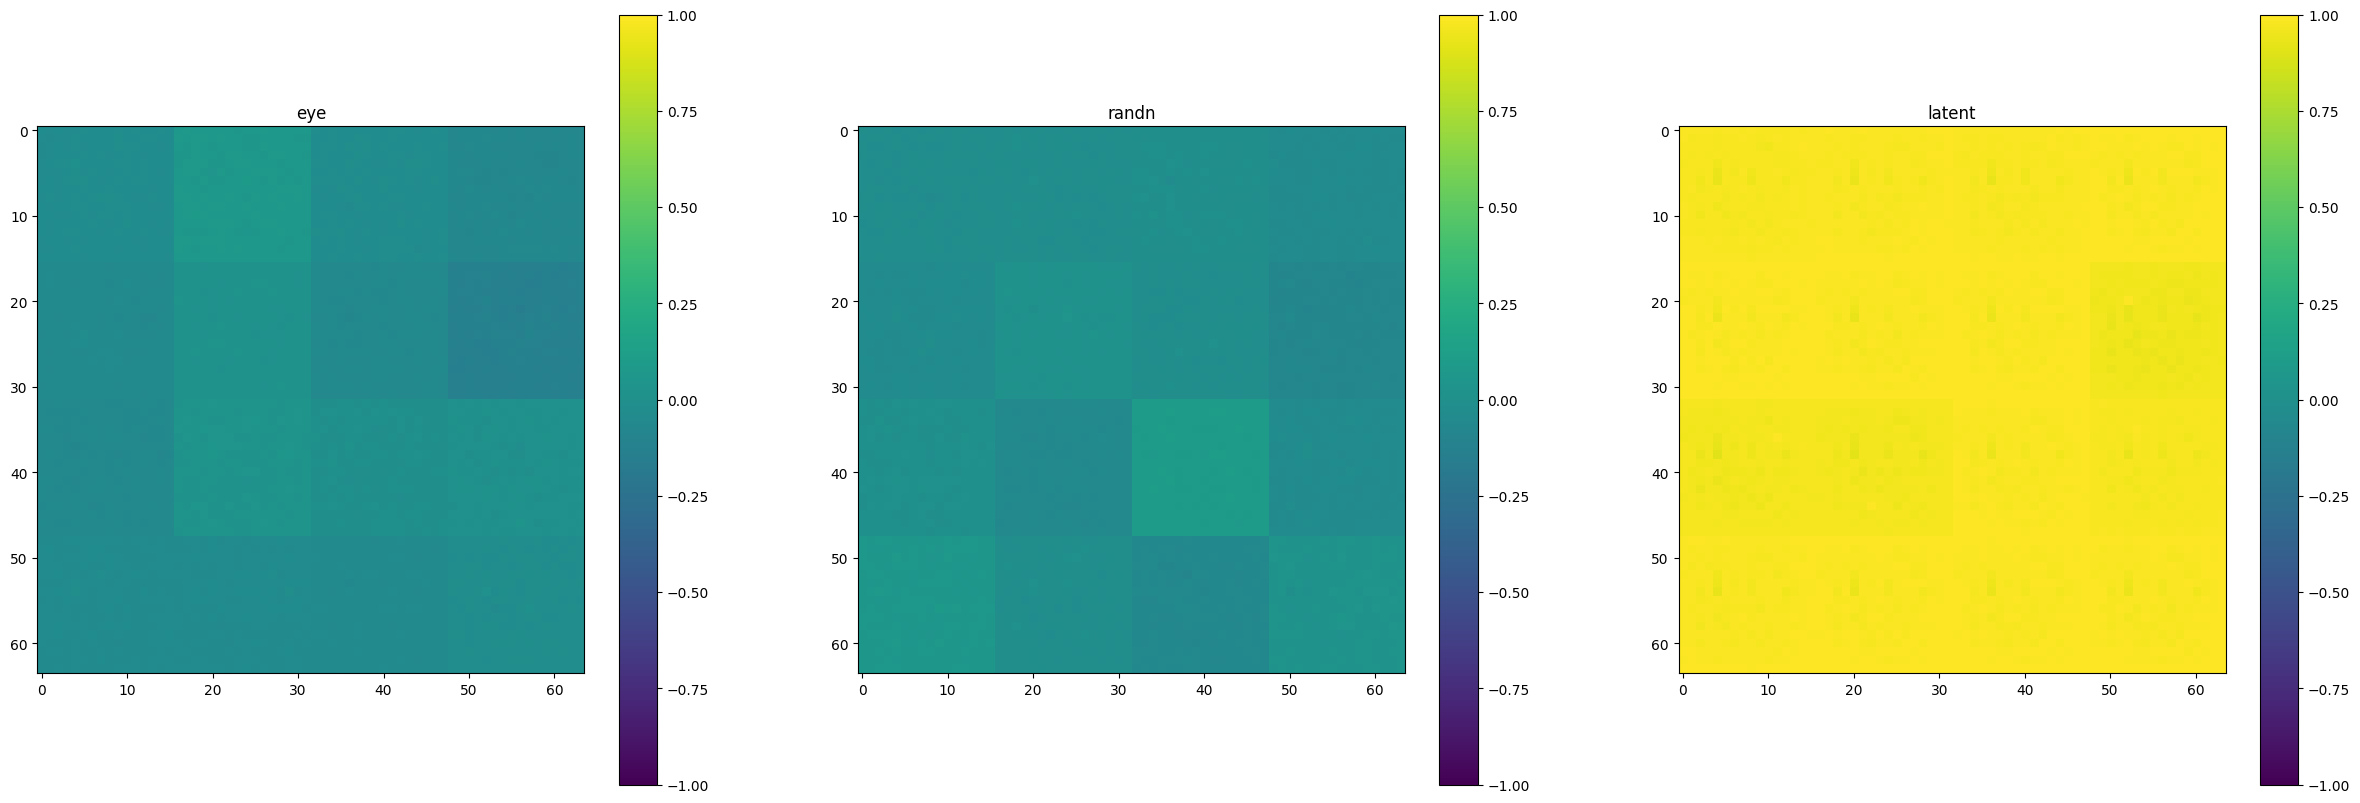

i=0, -0.04061593860387802, 0.030549759045243263, -0.07116569578647614
i=30, -0.39643341302871704, 0.3053569197654724, -0.7017903327941895
i=60, -2.426936388015747, 1.4297764301300049, -3.856712818145752
i=90, -2.603672742843628, 1.2243731021881104, -3.8280458450317383
i=120, -2.7199301719665527, 1.058254361152649, -3.778184413909912
i=150, -2.805116653442383, 0.9455738663673401, -3.750690460205078
i=180, -2.8345189094543457, 0.8950412273406982, -3.729560136795044
i=210, -2.9308433532714844, 0.7892091870307922, -3.720052480697632
i=240, -2.904111385345459, 0.7997986078262329, -3.7039098739624023
i=270, -2.937239646911621, 0.7592080235481262, -3.6964476108551025
i=300, -2.9694957733154297, 0.7204003930091858, -3.6898961067199707
i=330, -2.995820999145508, 0.6894084811210632, -3.685229539871216
i=360, -3.0089802742004395, 0.6721490621566772, -3.6811294555664062
i=390, -3.02024245262146, 0.6580674648284912, -3.678309917449951
i=420, -3.094654083251953, 0.5796681046485901, -3.67432212829589

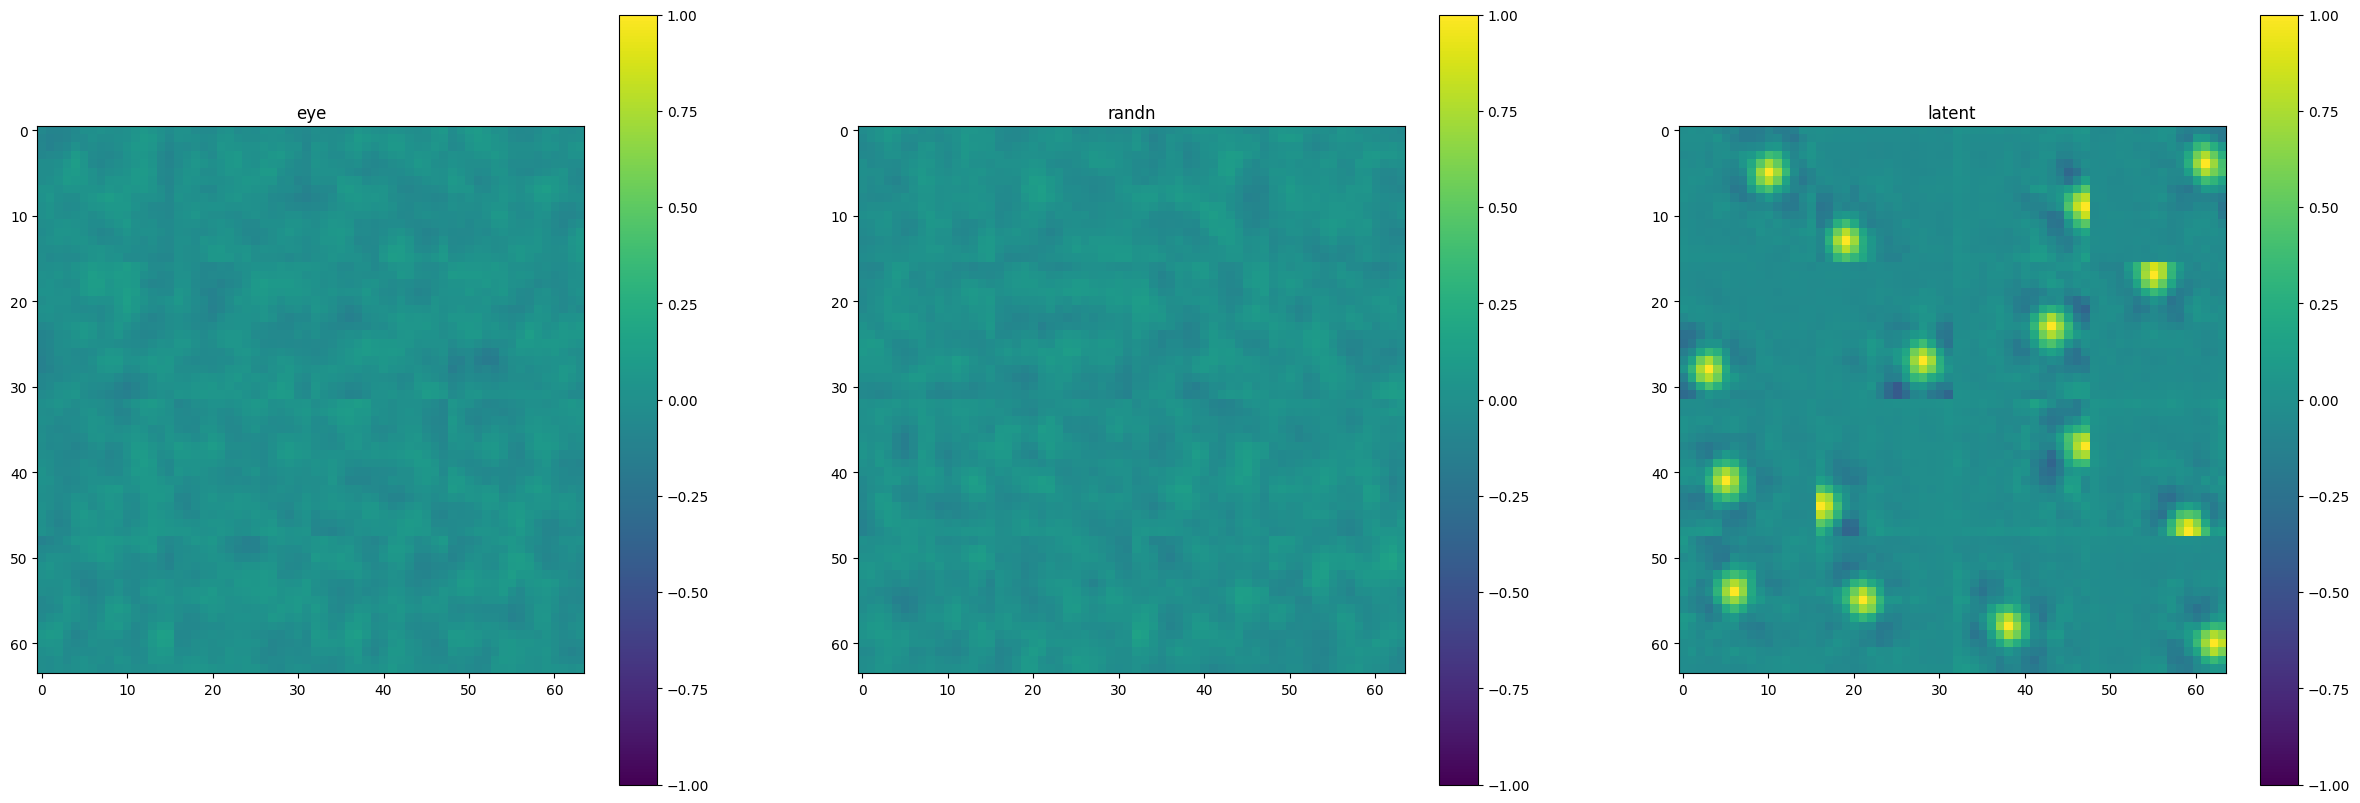

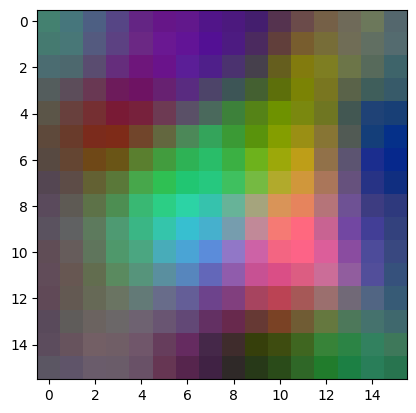

In [33]:
for latent_dim in [2, 4, 8, 16, 256, 512]:
    print(f"{latent_dim=}")
    net = Net(latent_dim=latent_dim)
    obs, info = env.reset()

    plt.figure(figsize=(30, 10))
    for i, goal_sample in enumerate(['eye', 'randn', 'latent']):
        plt.subplot(1, 3, i+1)
        plt.title(goal_sample)
        plt.imshow(rearrange(calc_rewmap(env, net, goal_sample=goal_sample, n_goals=16), '(H W) h w -> (H h) (W w)', H=4), vmin=-1., vmax=1.)
        plt.colorbar()
    plt.show()


    opt = torch.optim.Adam(net.parameters(), lr=1e-4)

    obs_all = env.all_possible_obs(flat=True)
    for i in range(1000):
        latent = net(obs_all)
        a = latent.reshape(len(env.map), len(env.map), -1)
        if np.random.rand()<0.5:
            x, y = a[:-1, :].flatten(0, 1), a[1:, :].flatten(0, 1)
        else:
            x, y = a[:, :-1].flatten(0, 1), a[:, 1:].flatten(0, 1)
        loss1 = lalign(x, y)
        loss2 = (lunif(x) + lunif(y)) / 2
        loss = 1.*loss1 + 1.0 *loss2
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        if i%30==0:
            print(f'{i=}, {loss.item()}, {loss1.item()}, {loss2.item()}')



    plt.figure(figsize=(30, 10))
    for i, goal_sample in enumerate(['eye', 'randn', 'latent']):
        plt.subplot(1, 3, i+1)
        plt.title(goal_sample)
        plt.imshow(rearrange(calc_rewmap(env, net, goal_sample=goal_sample, n_goals=16), '(H W) h w -> (H h) (W w)', H=4), vmin=-1., vmax=1.)
        plt.colorbar()
    plt.show()


    if latent_dim>=3:
        a = PCA(3).fit_transform(latent.detach().numpy())
        a = (a-a.min())/(a.max()-a.min())
        plt.imshow(a.reshape(16, 16, 3))
        plt.show()